# Model Order Reduction & Machine Learning - Project
## Nonlinear Elliptic problem (NEP) POD vs PINNs

### Importing library

In [15]:
import sys
sys.path.append('../../CppToPython')

In [16]:
import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

In [3]:
# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

### Initialize

In [4]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [5]:
np.random.seed(23)

# PART 1 - Problem definition
Let us consider the two-dimensional spatial domain $\Omega = (0, 1)^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2$, find $u(\mu)$ such that
$$
-\Delta u(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 u(\mu)} - 1) = g(x;\mu) \text{  (NEP1)}
$$
with homogeneous Dirichlet condition on the boundary, i.e. zero-boundary condition.

The forcing term, that does not depend on the parameters, defined as
$$
g(x;\mu) = g_1 = 100 \sin(2\pi x_0) \cos(2\pi x_1) \quad \forall x = (x_0, x_1) \in \Omega.
$$

**Tasks:**

1. Solve the problem by means of POD-Galerkin method over a Finite Element full order model -> using high fidelity element approximation of POD
2. Solve the problem with a parametric PINN -> find the NN structure to reduce the problem
3. Compare the two approaches in terms of computational costs and accuracy with respect to the full order model -> compare in terms of execution time & error
4. **Optional:** Solve the problem with the POD-NN approach and compare it to the other two strategies.

#### ------------------------------------------- Beginning of the evaluation of the exact solution problem -------------------------------------------

# 1 POD over a Finite Element full order model
## 1.0 PRELIMINARY ANALISYS
### High-fidelity computation error using a known exact solution
#### Exact solution definition
As a preliminar step, to evaluate the error of the solution computed using Newton method, we will apply the Newton algorithm to solve a PDE of which we know the exact solution. In particular, we'll consider an exact solution $\tilde{u}$ and compute the forcing term $\tilde{g}$ st it is solution to our differential problem. Then, we will solve the PDE using the Netwon schema and evaluate the error of the approximation of $\tilde{u}$ wrt the exact solution.

Take the exact solution 
$$\tilde{u}(x,y;\mu)= \mu_0xy(1-x)(1-y)$$
and compute the forcing term $\tilde{g}(x,y;\mu)$ st $$-\Delta \tilde{u}(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \tilde{g}(x, y;\mu)$$
To do so, compute the laplacian of $\tilde{u}$: $$\Delta \tilde{u}(\mu) = -2 \mu_0 (y(1-y) + x(1-x))$$ and substitute $\tilde{u}$ in the non linear term of the PDE : $$\frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \frac{\mu_0}{\mu_1} (e^{\mu_1 \mu_0xy(1-x)(1-y)} - 1 ) $$

Then, the forcing term for this problem is $$\tilde{g}(x,y;\mu) = 2 \mu_0 (y(1-y) + x(1-x)) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \mu_0xy(1-x)(1-y)} - 1) $$

Now consider the parametric PDE $-\Delta \tilde{u}(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \tilde{g}(x, y;\mu)$.

### Passage from Strong Formulation to Weak Formulation and Newton Scheme for the EXACT SOLUTION
**Mathematical note:** the weak formulation is derived by multiplication by a test function $v$ and integration by parts. We assume that $u \in H_0^1(\Omega)$, i.e. functions with weak square-integrable derivatives and null on the edge. This allows us to look for solutions in function spaces that are more regular than the strong formulation.

**Weak Formulation.**
Find $\tilde{u} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX = 0$$
Hence, the weak formulation is:
$$\int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX = \int_{\Omega} \tilde{g} v \, dX$$
where on the left can be found the unkown $\tilde{u}$ and on the right the forcing term.

**Definition of the Nonlinear Operator.**
Define the operator $F: H_0^1(\Omega) \to (H_0^1(\Omega))'$ such that for $u \in H_0^1(\Omega)$ and $v \in H_0^1(\Omega)$:
$$F(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX$$
Solving the PDE means finding $\tilde{u}$ st $F(\tilde{u})[v]=0$ for every $v$, which we solve using the Newton schema.

**Fréchet Derivative of $F(u)$.**
Calculate the Fréchet derivative $DF(u)[\delta u] \in (H_0^1(\Omega))'$ for an increment $\delta u \in H_0^1(\Omega)$. For every $v \in H_0^1(\Omega)$:
$$DF(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F(u + \epsilon \delta u)[v] - F(u)[v]}{\epsilon}$$
Consider each term of $F(u)[v]$ separately.

1.  **Linear Term.** $F_1(\tilde{u})[v] = \int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX$.
    $$DF_1(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \nabla \delta \tilde{u} \cdot \nabla v \, dX$$

2.  **Nonlinear Term.** $F_2(\tilde{u})[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX$.
    The Fréchet derivative of $F_2(u)$ is given by:
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \lim_{\epsilon \to 0} \frac{F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v]}{\epsilon}$$
    **Expansion of $F_2(\tilde{u} + \epsilon \delta \tilde{u})[v]$.**
    $\begin{align*}
    F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 (\tilde{u} + \epsilon \delta \tilde{u})} - 1) v \, dX\\
    &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta \tilde{u}} - 1) v \, dX
    \end{align*}$
    **Then**
    $$
    F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta u} - 1) v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} - 1) v \, dX
    $$
    $$= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta \tilde{u}} - e^{\mu_1 \tilde{u}}) v \, dX = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}} (e^{\mu_1 \epsilon \delta \tilde{u}} - 1) v \, dX
    $$

    **Division by $\epsilon$.**
    $$\frac{F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v]}{\epsilon} = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}} \frac{(e^{\mu_1 \epsilon \delta \tilde{u}} - 1)}{\epsilon} v \, dX$$
    **Notable Limit.**
    We use the notable limit $\lim_{t \to 0} \frac{e^{at} - 1}{t} = a$. In our case, $t = \epsilon$ and $a = \mu_1 \delta u(X)$. Thus:
    $$\lim_{\epsilon \to 0} \frac{e^{\mu_1 \epsilon \delta \tilde{u}(X)} - 1}{\epsilon} = \mu_1 \delta \tilde{u}(X)$$
    **Passing to the Limit.**
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \lim_{\epsilon \to 0} \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}(X)} \frac{(e^{\mu_1 \epsilon \delta \tilde{u}(X)} - 1)}{\epsilon} v(X) \, dX$$
    Assuming we can interchange the limit and the integral (which requires appropriate regularity conditions), we obtain:
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}(X)} (\mu_1 \delta \tilde{u}(X)) v(X) \, dX = \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}(X)} \delta \tilde{u}(X) v(X) \, dX$$

3.  **Term Independent of $\tilde{u}$.** $F_3(\tilde{u})[v] = - \int_{\Omega} \tilde{g} v \, dX$.
    $$DF_3(\tilde{u})[\delta \tilde{u}][v] = 0$$

**The Jacobian Operator (Fréchet Derivative) of $F(u)$ is therefore**
$$DF(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \nabla \delta \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}} \delta \tilde{u} v \, dX$$

**Newton Scheme.**
The Newton scheme to find the root of $F(\tilde{u}) = 0$ is given by:
$$DF(\tilde{u}_k)[\delta \tilde{u}] = -F(\tilde{u}_k)$$
where $\tilde{u}_k$ is the approximation at the $k$-th iteration and $\delta \tilde{u}_k = \tilde{u}_{k+1} - \tilde{u}_k$ is the increment to be found. In variational form, this is written:

Find $\delta \tilde{u}_k \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\left( \int_{\Omega} \nabla \delta \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \delta \tilde{u}_k v \, dX \right) * \delta \tilde{u} = - \left( \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX \right)$$
**Rewriting the equation for the next iteration $\tilde{u}_{k+1} = \tilde{u}_k + \delta \tilde{u}_k$.**
Find $\tilde{u}_{k+1} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$
\int_{\Omega} \nabla (\tilde{u}_{k+1} - \tilde{u}_k) \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} (\tilde{u}_{k+1} - \tilde{u}_k) v \, dX = - \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Rearranging the terms, we obtain the variational form of the linear system to be solved at each Newton iteration to find $\tilde{u}_{k+1}$:**
$$\int_{\Omega} \nabla \tilde{u}_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_{k+1} v \, dX = \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_k v \, dX - \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Which simplifies to**

$$\int_{\Omega} \nabla \tilde{u}_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_{k+1} v \, dX = \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_k v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Analisys of all the terms of the system**

$$\left( \int_{\Omega} \nabla \delta \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \delta \tilde{u}_k v \, dX \right) * \delta \tilde{u} = - \left( \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX \right)$$

1. Left-hand side (Jacobian applied to Newton increment):
       
    **Diffusion term**:  $
      \int_{\Omega} \nabla \delta \tilde{u}_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term** (derivative of the exponential term):  $
      \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \delta \tilde{u}_k v \, dX
      $

2. Right-hand side (Nonlinear residual at step \( u_k \)):

    **Diffusion term**:  $
      \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term**:  $
      \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX
      $
      
    **Source term**:  $
      \int_{\Omega} \tilde{g} v \, dX
      $

#### Error computation for the exact solution
Since we know the exact solution, when solving the high fidelity problem using Newton schema, we can compute exactly the error of approximation of $\tilde{u}$ with $\tilde{u}_k$:
$$\frac{||\tilde{u}_k - \tilde{u}||_{L^2}}{||\tilde{u}||_{L^2}}$$

#### Definition of the different terms for the exact solution
NB: We'll use the same terms also when solving the real problem (of unknown solution), except for the forcing term $g$.

These functions (```Elliptic_a```, ```Elliptic_c```) take a number of numPoints as input, construct an array full of 1s with numPoints elements. They then return a memory pointer (ctypes.data) - typical when you need to interface with C code, or with libraries that expect ‘raw’ arrays.

In [6]:
# Points on which we want to integrate - We leave the structure of Lab12

# Points for the diffusion term
def Elliptic_a(numPoints, points): 
	values_a = np.ones(numPoints, order='F') # Fortran order of memorization of the matrix: column by column
	return values_a.ctypes.data

# Points for the reaction term
def Elliptic_c(numPoints, points):
	values_c = np.ones(numPoints, order='F') 
	return values_c.ctypes.data    

# QUESTION? We need np.ones((2, numPoints), order='F')?
# ANSWER! No, only the advection term has a vector field as its coefficient --> hence, we need np.ones((2, numPoints), order='F')
#         only if we have advection term (that we do not have)

In [7]:
# NOTE: x=x_0, y=x_1

# Non linear reaction term
# numPoints := quadrature points
def Elliptic_non_linear_c(numPoints, points, u, u_x, u_y):
	vec_u = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in the quadrature points numPoints
	values_nl_c = vec_u
	return values_nl_c.ctypes.data

This function (```Elliptic_non_linear_der_f```) provides the local values of the gradient of u for an integral related to the diffusion term on the right-side of the equation.
$$\int_{\Omega} \nabla u_k \cdot \nabla v \, dX$$

The function takes the ```u_x``` and ```u_y``` derivatives, organises them into an array ```[ [u_x], [u_y] ]``` in column order, and returns the memory pointer of that array, to be used in an external computational context (probably in a numerical FEM-type method).

In [8]:
def Elliptic_non_linear_der_f(numPoints, points, u, u_x, u_y):
    # Converts u_x and u_y pointers or arrays to NumPy arrays
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
	values_nl_d_f = np.zeros((2, numPoints), order='F')

    # Inserts the partial derivatives of u into the new array values_nl_d_f
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
    
	return values_nl_d_f.ctypes.data

The function `Elliptic_non_linear_f` evaluates the term:

$$
f(u) = \frac{\mu_0}{\mu_1}(e^{\mu_1 u} - 1)
$$

...in `numPoints` points, and returns the values as C-compatible arrays, to be integrated into the second member (right) of the weak form of a nonlinear PDE problem.


This function is therefore relative to the nonlinear reaction term:
$$\int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX
$$

In [9]:
# Nonlinear reaction term
def Elliptic_non_linear_f(numPoints, points, u, u_x, u_y): 
    vec_u = gedim.make_nd_array(u, numPoints, np.double)
    vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
    vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
    values_nl_f = (mu_0/mu_1) * (np.exp(mu_1*vec_u)-1) # Computation of f
    
    return values_nl_f.ctypes.data

Set the exact solution, it is a regular solution defined in the omega domain,
$$
u = \mu_0 xy(1-x)(1-y)
$$

In [10]:
def Elliptic_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

    # Definition of u
	values_ex = mu_0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
    
	return values_ex.ctypes.data

In [11]:
def Elliptic_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0: # wrt x
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:]) # 16⋅(1−2x)⋅y⋅(1−y)
	elif direction == 1: # wrt y
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]) # 16⋅(1−2y)⋅x⋅(1−x)
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

In [12]:
# Refer to the g that we computed wrt the exact solution u

# Forcing term for evaluating the error
def Elliptic_exactSolution_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    
    # Definition of u
    # values_ex = 2*mu_0*(y*(1-y)+x*(1-x)) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*x*y*(1-x)(1-y)) -1)
    values_ex = 2*mu_0*(matPoints[1,:]*(1-matPoints[1,:])+matPoints[0,:]*(1-matPoints[0,:])) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*matPoints[0,:]*matPoints[1,:]*(1-matPoints[0,:])*(1-matPoints[1,:])) -1)
    
    return values_ex.ctypes.data

These **`Ones`**, **`Zeros`**, and their **`Derivative`** versions serve a very practical and common purpose in numerical methods (especially FEM/FDM/FVM): **provide constant functions** or **derivative constants** to be used as:

* **known terms** (constant sources)
**boundary conditions** (e.g. Dirichlet or Neumann constants)
* **test or debug checks**
* **auxiliary functions** to test code behaviour


| Function | Purpose |
| ----------------- | ------------------------------------------- |
| `Ones` | Constant value 1 (e.g. $f(x)=1$) |
| `OnesDerivative` | Dummy ‘constant’ derivative (for testing) |
| `Zeros` | Constant value 0 (e.g. $u=0$, $f=0$) |
| `ZerosDerivative` | Null Derivative (e.g. homogeneous Neumann, test) |

In [13]:
def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

#### Define the High Fidelity Simulation Parameters
For a parametric problem we need not only the order of the discretization, but also the parametric space definition.

In [14]:
order = 1 # Start from 1, at the END we will decide if we have to improve the order
P = [0.1, 1.] # Parametric space

| Error | Meaning | When to use it |
| -------------------------- | ------------------------------------------------------------------------------------ | --------------------------------------------------------------------------- |
| `rel_error_L2` | Relative error in norm $L^2$: average accuracy of the solution | When you are interested in the **average value solution**, e.g. states |
| `rel_error_H1` | Relative error in norm $H^1$: accuracy including derivatives | When you are interested in **energy** or **derivative** (e.g. gradients, flows) |
| `residual_norm / u_normL2` | Relative residual in $L^2$: how well the solution satisfies the system (not accuracy) | Serves as a **criterion of convergence of Newton's method** |

#### Mesh size analysis
#### Mean error decrease with decreasing mesh size
We evaluate how a decrement in the mesh size leads to a smaller error: in particular, fixing a mesh size, for a sample of 100 parameters $\mu=(\mu_0, \mu_1) \in [0.1,1]^2$, we compute the Newton approximation of the solution (for the exact solution problem) and we evaluate its error wrt the known exact solution. We then average the errors over the 100 parameter samples for that mesh size. We repeat this operation for decreasing values of the mesh size (starting from 0.1 and halfing it at every iteration), until the order of $10^{-4}$, and finally we plot the resulting mean errors of the Newton algorithm wrt the mesh size values.

In [ ]:
# Decide the right mesh size - Compute the error and plot the graph

# Constant definition
num_samples = 100
initial_mesh_size = 0.1
min_mesh_size = 1e-4
max_iterations = 100
newton_tol = 1e-8

# Dict to accumulate errors
error_L2_sum = {}
error_H1_sum = {}
error_L2_dict = {}
error_H1_dict = {}


# Definition of the mesh_size_list (equal for each iteration)
mesh_sizes_list = []
ms = initial_mesh_size
while ms > min_mesh_size:
    mesh_sizes_list.append(ms)
    error_L2_sum[ms] = 0.0
    error_H1_sum[ms] = 0.0
    ms /= 2

# Definition of 100 sample of mu_0, mu_1
mu_0_sample = np.random.uniform(0.1, 1, 100) # Change to 100 if necessary
mu_1_sample = np.random.uniform(0.1, 1, 100) # Change to 100 if necessary


# Loop on the (mu_0, mu_1)
for mu_0, mu_1 in zip(mu_0_sample, mu_1_sample):
    
    mesh_size = initial_mesh_size
    
    for mesh_size in mesh_sizes_list:
        
        du_norm = 1.0
        u_k_norm = 1.0
        num_iteration = 1

        # Build the domain
        domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
        [meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
        discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
        [problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
        u_strong = np.zeros(problemData['NumberStrongs'], order='F')
        u_k = np.zeros(problemData['NumberDOFs'], order='F') 

        zero = np.zeros(problemData['NumberDOFs'], order='F')
        du = zero
        u_k = zero

        # Newton Loop
        while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 
            [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
            [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
            forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_exactSolution_g, problemData, lib)
            forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
            forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)

            du = gedim.LUSolver(stiffness + reaction, forcingTerm_g - forcingTerm_v - forcingTerm_der_v, lib)
            u_k = u_k + du

            # Compute the error
            du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
            u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
            num_iteration += 1

        exact_error_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, u_k, u_strong, lib)
        u_exact_norm_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, zero, u_strong, lib)
        error_L2_dict[mesh_size] = exact_error_L2 / u_exact_norm_L2
        error_L2_sum[mesh_size] += exact_error_L2 / u_exact_norm_L2

        exact_error_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, u_k, u_strong, lib)
        u_exact_norm_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, zero, u_strong, lib)
        error_H1_sum[mesh_size] += exact_error_H1 / u_exact_norm_H1
        error_H1_dict[mesh_size] = exact_error_H1 / u_exact_norm_H1

# Compute the mean error
error_L2_avg = [error_L2_sum[h] / num_samples for h in mesh_sizes_list]
error_H1_avg = [error_H1_sum[h] / num_samples for h in mesh_sizes_list]


Exception ignored on calling ctypes callback function: <function Elliptic_exactSolution_g at 0x7f51238d4280>
Traceback (most recent call last):
  File "/tmp/ipykernel_2491/811208238.py", line 5, in Elliptic_exactSolution_g
  File "/content/RBM_ML_2025/Lab13/../../CppToPython/GeDiM4Py.py", line 18, in make_nd_matrix
    def make_nd_matrix(c_pointer, shape, dtype=np.double, order='F', own_data=True):
KeyboardInterrupt: 


In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(mesh_sizes_list, error_L2_avg, marker='o', label='Mean relative error L2')
plt.plot(mesh_sizes_list, error_H1_avg, marker='s', label='Mean relative error H1')

# Highlight first mesh that meets the error threshold
if first_mesh_satisfying_condition:
    idx = mesh_sizes_list.index(first_mesh_satisfying_condition)
    plt.scatter(mesh_sizes_list[idx], error_L2_avg[idx], color='red', label='First mesh with L2≤1e-2 and H1<1e-2', zorder=5)
    plt.scatter(mesh_sizes_list[idx], error_H1_avg[idx], color='red', zorder=5)

# Highlight mesh with smallest error
if best_mesh:
    idx = mesh_sizes_list.index(best_mesh)
    plt.scatter(mesh_sizes_list[idx], error_L2_avg[idx], color='green', marker='*', s=150, label='Best mesh (lowest L2)', zorder=5)
    plt.scatter(mesh_sizes_list[idx], error_H1_avg[idx], color='green', marker='*', s=150, zorder=5)

plt.gca().invert_xaxis()
plt.xlabel('Mesh size')
plt.ylabel('Mean relative errors')
plt.title('Mean relative errors on 100 (mu_0, mu_1) with respect to mesh size')
plt.legend()

# Set scientific notation for y-axis around 1e-2
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))  # ← scale set to scientific (1e-2, etc.)

plt.grid(True, linestyle="--")
plt.tight_layout()
plt.savefig("mean_relative_errors_plot.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print results
if first_mesh_satisfying_condition is not None:
    idx = mesh_sizes_list.index(first_mesh_satisfying_condition)
    print(f"First mesh with L2 ≤ 1e-2 and H1 < 1e-2: {first_mesh_satisfying_condition} "
          f"(L2 = {error_L2_avg[idx]:.2e}, H1 = {error_H1_avg[idx]:.2e})")
else:
    print("No mesh satisfies L2 ≤ 1e-2 and H1 < 1e-2.")

if best_mesh is not None:
    idx = mesh_sizes_list.index(best_mesh)
    print(f"Best mesh with lowest L2 error (or fallback): {best_mesh} "
          f"(L2 = {error_L2_avg[idx]:.2e}, H1 = {error_H1_avg[idx]:.2e})")


**Results**
We find the two most suitable mesh sizes to be the greates and smallest ones providing an error of at least $10^{-3}$
1) $0.00312$ higher error but faster computation (less points to evaluate in the next steps)
2) $0.00019$ smaller error but more computationally demanding (less points to evaluate in the next steps)

### Check of theoretical results 
From the theory we know that the approximation error should decrease exponentially with decreasing mesh size. In particular, denoting $h$ the mesh size (ie the edge of the mesh polygon - triangle for us) and $s$ the order of the mesh, for the $L^2$ and $H^1$ norms we know :
$$Error_{L^2}(h) = Error_{L^2}(h_0)(\frac{h}{h_0})^{s+1} $$
$$Error_{H^1}(h) = Error_{H^1}(h_0)(\frac{h}{h_0})^{s} $$

where $h_0$ is the starting mesh size and $Error_{L^2}(h) = \frac{ ||\tilde{u}_k - \tilde{u}||_{L^2} }{ || \tilde{u}||_{L^2} }$, ie the relative error of the approximation computed with mesh size h (at convergence of the method) wrt the exact solution. Similarly, $Error_{H^1}(h) =  \frac{ ||\tilde{u}_k - \tilde{u}||_{H^1} }{ || \tilde{u}||_{H^1} } $

We now check if the expected behavior is also observed experimentally in order to assess the quality of the method implementation.

NB: We plot the log of the error and expect to have a linear decay with decreasing mesh size

In [ ]:
# Sort mesh_sizes in ascending order
mesh_sizes = sorted(error_L2_dict.keys())
error_L2 = [error_L2_dict[h] for h in mesh_sizes]
error_H1 = [error_H1_dict[h] for h in mesh_sizes]

# FEM order
s = order

# Reference point for theoretical curves
h0 = mesh_sizes[0]
e_L2_0 = error_L2[0]
e_H1_0 = error_H1[0]

# Theoretical curves
theoretical_L2 = [e_L2_0 * (np.sqrt(h / h0))**(s+1) for h in mesh_sizes]
theoretical_H1 = [e_H1_0 * (np.sqrt(h / h0))**(s)   for h in mesh_sizes]

# Compute slopes (convergence rates) using last two mesh sizes
def compute_slope(errors, hs):
    hs_length = [np.sqrt(h) for h in hs[-2:]]  # Convert from area to length
    log_e = np.log(errors[-2:])
    log_h = np.log(hs_length)
    return (log_e[1] - log_e[0]) / (log_h[1] - log_h[0])

slope_L2 = compute_slope(error_L2, mesh_sizes)
slope_H1 = compute_slope(error_H1, mesh_sizes)

# Colors
color_L2 = '#1f77b4'
color_H1 = '#ff7f0e'
color_L2_theory = '#aec7e8'
color_H1_theory = '#ffbb78'

# Plot
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')  # White background
ax.loglog(mesh_sizes, error_L2, 'o-', color=color_L2, label=f'Relative L2 error (slope ≈ - {slope_L2:.2f})', markersize=6)
ax.loglog(mesh_sizes, error_H1, 's-', color=color_H1, label=f'Relative H1 error (slope ≈ - {slope_H1:.2f})', markersize=6)
ax.loglog(mesh_sizes, theoretical_L2, '--', color=color_L2_theory, label=f'Theoretical L2 (h^{s+1})', linewidth=1.5)
ax.loglog(mesh_sizes, theoretical_H1, '--', color=color_H1_theory, label=f'Theoretical H1 (h^{s})', linewidth=1.5)

# Labels and title
ax.set_xlabel('Mesh size (h)', fontsize=12)
ax.set_ylabel('Relative error', fontsize=12)
ax.set_title('Error convergence with respect to mesh size (log-log scale)', fontsize=14)

# Remove grid for clean look
ax.grid(False)

# Invert X-axis (optional)
ax.invert_xaxis()

# Legend
ax.legend(fontsize=11)

# Tight layout
plt.tight_layout()

# Save plot
plt.savefig("convergence_plot.png", dpi=300, bbox_inches='tight', facecolor='white')  # PNG, high-res

# Show plot
plt.show()

In [ ]:
# Convert area to actual mesh size (h)
h_values = [np.sqrt(h) for h in mesh_sizes]  # Assuming h = area, so sqrt gives length scale

log_h = np.log(h_values)
log_L2 = np.log(error_L2)
log_H1 = np.log(error_H1)

order_L2_obs, _ = np.polyfit(log_h, log_L2, 1)
order_H1_obs, _ = np.polyfit(log_h, log_H1, 1)

print(f"Observed order (L2): {abs(order_L2_obs):.2f}")
print(f"Observed order (H1): {abs(order_H1_obs):.2f}")


**Results**  : It works as expected.

**Answer**. Yes, it works as expected, if we consider the edge of the mesh and not the area (hence computing the np.sqrt(mesh_size)) we obtain the right and expected value around
Observed order (L2) = 2
Observed order (H1) = 1

#### Tradeoff between velocity and accuracy for mesh sizes : error of approximation vs run time
Based on the previous results, we will now evaluate the trade-off between calculation time and error for all Newton iterations, focusing on two mesh sizes: **0.003** and **0.0004**. The aim is to determine whether the increase in calculation time is justified by the change in accuracy obtained.

#### mesh_size = 0.00312

In [ ]:
# ERROR COMPUTATION USING EXACT SOLUTION 
# OPTION 1 - mesh_size = 
sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

newton_tol = 1e-8
mesh_size = 0.00312

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
zero = np.zeros(problemData['NumberDOFs'], order='F') # Null function

max_iterations = 100
mean_time_000312 = 0
rel_error_L2_mean = 0
rel_error_H1_mean = 0

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):

    start_time = time.time()

    u_k = zero
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_exactSolution_g, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

        # Compute the errors
        exact_error_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, u_k, u_strong, lib) # ||u_k - u_exact|| l^2-norm 
        u_exact_norm_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, zero, u_strong, lib) # ||u_exact|| l^2-norm 
        rel_error_L2 = exact_error_L2 / u_exact_norm_L2 # Relative error ||u_k - u_exact|| / ||u_exact|| l^2-norm 
        
        
        exact_error_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, u_k, u_strong, lib) # ||u_k - u_exact|| H^1-norm 
        u_exact_norm_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, zero, u_strong, lib) # ||u_exact|| H^1-norm 
        rel_error_H1 = exact_error_H1 / u_exact_norm_H1 # Relative error ||u_k - u_exact|| / ||u_exact|| H^1-norm 
        
        num_iteration = num_iteration + 1

    stop_time = time.time() - start_time
    rel_error_L2_mean += rel_error_L2
    rel_error_H1_mean += rel_error_H1
    mean_time_000312 += stop_time
    
    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14} {'rel_err_H1':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f}"
      f"{(num_iteration-1):<6d} {rel_error_L2:<14.2e} {rel_error_H1:<14.2e}")

mean_time_000312 = mean_time_000312/len(sample_mu_0)
rel_error_L2_mean = rel_error_L2_mean/len(sample_mu_0)
rel_error_H1_mean = rel_error_H1_mean/len(sample_mu_0)

print(f"Snapshot computation for one (mu_0, mu_1) is: {mean_time_000312}")    
print(f"The mean relative error L2 for one (mu_0, mu_1) is: {rel_error_L2_mean}")    
print(f"The mean relative error H1 for one (mu_0, mu_1) is: {rel_error_H1_mean}")    

In [ ]:
# Just to check the final u_k, mu_0, mu_1
last_u_k_exact = u_k

In [ ]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)

# To export the solution
gedim.ExportSolution(Elliptic_exactSolution, last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

#### mesh_size = 0.00019

In [ ]:
# ERROR COMPUTATION USING EXACT SOLUTION 
# OPTION 2 - mesh_size = 0.003
sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

mesh_size = 0.00019

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
zero = np.zeros(problemData['NumberDOFs'], order='F') # Null function
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

max_iterations = 100

mean_time_000019 = 0
rel_error_L2_mean_2 = 0
rel_error_H1_mean_2 = 0


for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):

    start_time = time.time()
    
    u_k = zero
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_exactSolution_g, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

        # Compute the errors
        exact_error_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, u_k, u_strong, lib) # ||u_k - u_exact|| l^2-norm 
        u_exact_norm_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, zero, u_strong, lib) # ||u_exact|| l^2-norm 
        rel_error_L2 = exact_error_L2 / u_exact_norm_L2 # Relative error ||u_k - u_exact|| / ||u_exact|| l^2-norm 
        
        exact_error_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, u_k, u_strong, lib) # ||u_k - u_exact|| H^1-norm 
        u_exact_norm_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, zero, u_strong, lib) # ||u_exact|| H^1-norm 
        rel_error_H1 = exact_error_H1 / u_exact_norm_H1 # Relative error ||u_k - u_exact|| / ||u_exact|| H^1-norm 

        
        num_iteration = num_iteration + 1

    stop_time = time.time() - start_time
    rel_error_L2_mean_2 += rel_error_L2
    rel_error_H1_mean_2 += rel_error_H1
    mean_time_000019 += stop_time
    
    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14} {'rel_err_H1':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f}"
      f"{(num_iteration-1):<6d} {rel_error_L2:<14.2e} {rel_error_H1:<14.2e}")

mean_time_000019 = mean_time_000019/len(sample_mu_0)
rel_error_L2_mean_2 = rel_error_L2_mean_2/len(sample_mu_0)
rel_error_H1_mean_2 = rel_error_H1_mean_2/len(sample_mu_0)

print(f"Snapshot computation for one (mu_0, mu_1) is: {mean_time_000019}")    
print(f"The mean relative error L2 for one (mu_0, mu_1) is: {rel_error_L2_mean_2}")    
print(f"The mean relative error H1 for one (mu_0, mu_1) is: {rel_error_H1_mean_2}")  

In [ ]:
# Just to check the final u_k, mu_0, mu_1
last_u_k_exact = u_k

In [ ]:
# Plot and show the solution
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)

# To export the solution
gedim.ExportSolution(Elliptic_exactSolution, last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

In [ ]:
times = np.array([mean_time_1, mean_time_2])  # e.g., np.array([0.5, 3.2])
errors = np.array([mean_error_L2_1, mean_error_L2_2])  # e.g., np.array([1e-2, 1e-3])
labels = ['mesh = 0.00312', 'mesh = 0.00019']

# Consistent colors
colors = ['#1f77b4', '#d62728']

plt.figure(figsize=(9, 6))

# Line connecting the points to emphasize the trade-off
plt.plot(times, errors, linestyle='--', color='gray', linewidth=1, zorder=1)

# Points
for i in range(len(times)):
    plt.scatter(times[i], errors[i], color=colors[i], s=100, label=labels[i], zorder=2)
    plt.text(times[i]*1.05, errors[i], labels[i], fontsize=12, verticalalignment='center')

# Optional: log scale if range is very different
plt.xscale('log')
plt.yscale('log')

# Highlight "optimal" solution (e.g., the best compromise)
best_idx = np.argmin(errors / times)  # smallest error/time ratio
plt.scatter(times[best_idx], errors[best_idx], 
            edgecolors='black', facecolors='none', s=250, linewidths=2, zorder=3)

# Labels and style
plt.xlabel('Mean Execution Time [s]', fontsize=13)
plt.ylabel('Mean Relative Error (L2 norm)', fontsize=13)
plt.title('Trade-off between Accuracy and Computational Cost', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

#### Results of exact solution problem solving
Newton method computes accurate enough snapshots (exact error of the order $10^{-3}$ in $L^2$-norm and $10^{-2}$ in $H^1$-norm)

**Performance Metrics for Different Mesh Sizes**

| Metric                                      | Mesh Size = 0.00312 | Mesh Size = 0.00019 |
| :------------------------------------------ | :------------------ | :------------------ |
| Snapshot Computation Time (s)               | 0.5948              | 11.2261             |
| Mean Relative Error (L2 Norm)               | 0.0089              | 0.0005              |
| Mean Relative Error (H1 Norm)               | 0.0937              | 0.0224              |

Based on these results, the **larger mesh size (0.00312)** demonstrates a significantly lower computational cost while still yielding acceptable accuracy, particularly concerning the L2 error. This suggests that for applications where computational efficiency is a primary concern, the larger mesh size presents a favorable trade-off between performance and accuracy.

#### --------------------------------------------- End of the evaluation of the exact solution problem -------------------------------------------------

## 1.1 High fidelity solution of NEP1

### Passage from Strong Formulation to Weak Formulation and Newton Scheme for NEP1

Starting from the strong form of the PDE, we multiply both sides of the equation by a test function $ v \in V $, where $ V $ is a suitable function space (typically $ H^1(\Omega) $ or similar). Then, we integrate the resulting expression over the spatial domain $ \Omega $.

To handle the diffusion term, we apply integration by parts (or the divergence theorem), which transfers the derivative from the solution $ u $ to the test function $ v $, thereby reducing the differentiability requirement on $ u $. For the advection term, we apply the divergence theorem as well, which is often useful when dealing with convective fluxes.

After these transformations, we obtain the weak formulation of the problem, which is better suited for numerical approximation, especially in the finite element framework.

**Consider the homogeneous Dirichlet problem for the equation:**
$$-\Delta u(X; \mu)+\frac{\mu_0}{\mu_1} (e^{\mu_1 u(X;\mu)}-1) = g(X;\mu) \quad \text{in } \Omega \text{ where } X = (x,y)$$
$$u = 0 \quad \text{on } \partial \Omega$$
where $\Omega \subset \mathbb{R}^2$ is a bounded domain with a regular boundary $\partial \Omega$. We seek a solution $u$ in $H_0^1(\Omega)$.

**Weak Formulation.**
Find $u \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX = 0$$
Hence, the weak formulation is:
$$\int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX = \int_{\Omega} g v \, dX$$
where on the left can be found the unkown $u$ and on the right the forcing term.

**Definition of the Nonlinear Operator.**
Define the operator $F: H_0^1(\Omega) \to (H_0^1(\Omega))'$ such that for $u \in H_0^1(\Omega)$ and $v \in H_0^1(\Omega)$:
$$F(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX$$

**Fréchet Derivative of $F(u)$.**
Calculate the Fréchet derivative $DF(u)[\delta u] \in (H_0^1(\Omega))'$ for an increment $\delta u \in H_0^1(\Omega)$. For every $v \in H_0^1(\Omega)$:
$$DF(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F(u + \epsilon \delta u)[v] - F(u)[v]}{\epsilon}$$
Consider each term of $F(u)[v]$ separately.

1.  **Linear Term.** $F_1(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX$.
    $$DF_1(u)[\delta u][v] = \int_{\Omega} \nabla \delta u \cdot \nabla v \, dX$$

2.  **Nonlinear Term.** $F_2(u)[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX$.
    The Fréchet derivative of $F_2(u)$ is given by:
    $$DF_2(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F_2(u + \epsilon \delta u)[v] - F_2(u)[v]}{\epsilon}$$
    **Expansion of $F_2(u + \epsilon \delta u)[v]$.**
    \begin{align*}
    F_2(u + \epsilon \delta u)[v] &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 (u + \epsilon \delta u)} - 1) v \, dX \\
    &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - 1) v \, dX
    \end{align*}
    **Then**
    $$
    F_2(u + \epsilon \delta u)[v] - F_2(u)[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - 1) v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} - 1) v \, dX
    $$
    $$= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - e^{\mu_1 u}) v \, dX = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u} (e^{\mu_1 \epsilon \delta u} - 1) v \, dX
    $$

    **Division by $\epsilon$.**
    $$\frac{F_2(u + \epsilon \delta u)[v] - F_2(u)[v]}{\epsilon} = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u} \frac{(e^{\mu_1 \epsilon \delta u} - 1)}{\epsilon} v \, dX$$
    **Notable Limit.**
    We use the notable limit $\lim_{t \to 0} \frac{e^{at} - 1}{t} = a$. In our case, $t = \epsilon$ and $a = \mu_1 \delta u(X)$. Thus:
    $$\lim_{\epsilon \to 0} \frac{e^{\mu_1 \epsilon \delta u(X)} - 1}{\epsilon} = \mu_1 \delta u(X)$$
    **Passing to the Limit.**
    $$DF_2(u)[\delta u][v] = \lim_{\epsilon \to 0} \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u(X)} \frac{(e^{\mu_1 \epsilon \delta u(X)} - 1)}{\epsilon} v(X) \, dX$$
    Assuming we can interchange the limit and the integral (which requires appropriate regularity conditions), we obtain:
    $$DF_2(u)[\delta u][v] = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u(X)} (\mu_1 \delta u(X)) v(X) \, dX = \int_{\Omega} \mu_0 e^{\mu_1 u(X)} \delta u(X) v(X) \, dX$$

3.  **Term Independent of $u$.** $F_3(u)[v] = - \int_{\Omega} g v \, dX$.
    $$DF_3(u)[\delta u][v] = 0$$

**The Jacobian Operator (Fréchet Derivative) of $F(u)$ is therefore**
$$DF(u)[\delta u][v] = \int_{\Omega} \nabla \delta u \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u} \delta u v \, dX$$

**Newton Scheme.**
The Newton scheme to find the root of $F(u) = 0$ is given by:
$$DF(u_k)[\delta u] = -F(u_k)$$
where $u_k$ is the approximation at the $k$-th iteration and $\delta u_k = u_{k+1} - u_k$ is the increment to be found. In variational form, this is written:

Find $\delta u_k \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\left( \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX \right) * \delta u = - \left( \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX - \int_{\Omega} g v \, dX \right)$$
**Rewriting the equation for the next iteration $u_{k+1} = u_k + \delta u_k$.**
Find $u_{k+1} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$
\int_{\Omega} \nabla (u_{k+1} - u_k) \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} (u_{k+1} - u_k) v \, dX = - \int_{\Omega} \nabla u_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$

**Rearranging the terms, we obtain the variational form of the linear system to be solved at each Newton iteration to find $u_{k+1}$:**$$\int_{\Omega} \nabla u_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_{k+1} v \, dX = \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_k v \, dX - \int_{\Omega} \nabla u_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$

**Which simplifies to**

$$\int_{\Omega} \nabla u_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_{k+1} v \, dX = \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_k v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$

#### Analisys of all the terms of the system

$$\left( \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX \right) * \delta u = - \left( \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX - \int_{\Omega} g v \, dX \right)$$

1. Left-hand side (Jacobian applied to Newton increment):
       
    **Diffusion term**:  $
      \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term** (derivative of the exponential term):  $
      \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX
      $

2. Right-hand side (Nonlinear residual at step \( u_k \)):

    **Diffusion term**:  $
      \int_{\Omega} \nabla u_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term**:  $
      \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX
      $
      
    **Source term**:  $
      \int_{\Omega} g v \, dX
      $

**Newton's method:** To solve the non-linear equation $A(u) = f$ we resort to an iterative approach. At iteration $k$, we update the solution with:

$$
u^{k+1} = u^k + \delta u^k
$$

where $\delta u^k$ solves the linear system:

$$
A'(u^k)\delta u^k = f - A(u^k)
$$

Convergence is guaranteed under appropriate conditions on $A$ (e.g. continuity and invertibility of the differential).

#### Error computation for NEP1
In this context **we are not looking for the error with respect to the analytical solution**, since we do not know it, but rather we want to calculate:
$$
E_{abs} = \| \delta u \|_{L^2} = \| u^{(k+1)} - u^{(k)} \|_{L^2}
$$
To do this, simply pass `du` as the **numerical solution** and the function `Zeros` as the **exact solution**:

`du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)`

To find the relative error, we compute also the norm the last approximation  $\| u^{(k+1)} \|_{L^2} $:

`u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)`

and divide the absolute error by it, getting:
$$ E_{rel} = \frac{\| \delta u \|_{L^2} }{\| u_{k+1} \|_{L^2}}= \frac{ \| u^{(k+1)} - u^{(k)} \|_{L^2}}{\| u^{(k+1)} \|_{L^2}} $$ 
`rel_error = du_norm / u_k_norm`

This is done to monitor **how much the solution changes with each iteration**. It is a common **stop criterion** for non-linear methods.

#### Mesh and domain definition

In [17]:
# Fix the right domain
mesh_size = 0.00312

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

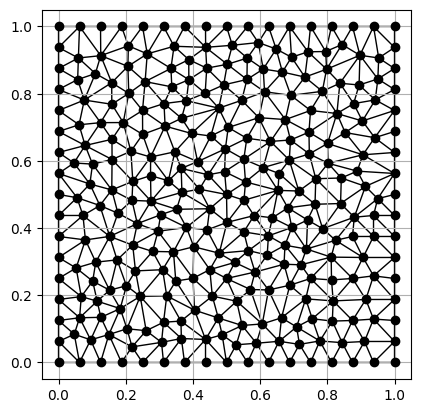

In [18]:
gedim.PlotMesh(mesh)

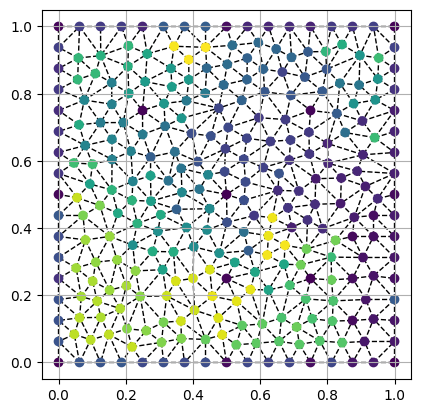

In [19]:
gedim.PlotDofs(mesh, dofs, strongs)

In [20]:
# Definition of the forcing term g_1
def Elliptic_g_1(numPoints, points): 
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double) # X
    # g_1(X,mu) = 100*sin(2pi*x)*cos(2pi*y), X=(x,y)
    values_g = 100*np.sin(2*np.pi*matPoints[0,:])*np.cos(2*np.pi*matPoints[1,:])
    return values_g.ctypes.data

**Sequence initialization**
| Variable   | What it represents                          | Initialization   | Use                                   |
|------------|---------------------------------------------|------------------|---------------------------------------|
| `u_k`      | Unknown **numerical** solution (free DOFs)  | $u = 0$          | Iterative solver input                |
| `u_strong` | **conditional** solution (Dirichlet conditions) | $u = 0$          | Used to impose values on edges        |

In [21]:
# Initialization of the guess of the solution --> the NM converges rapidly if we start not far away from the solution
u_k = np.zeros(problemData['NumberDOFs'], order='F') 
u_strong = np.zeros(problemData['NumberStrongs'], order='F') # Vector containing the strongly imposed components of the solution, ie Dirichlet conditions

#### Newton method for high fidelity snapshots computation

In [22]:
# RELATIVO A G_1

sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

snapshots_matrix = []
convergence_history = []  
max_iterations = 100
newton_tol = 1e-8

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1
    du_norms_for_sample = []
    num_iteration = 1
    rel_error = 0

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        # CAN WE DONE BETTER?
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        du_norms_for_sample.append(du_norm)
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

    
        # Compute the relative error of two consecutive iterations
        rel_error = du_norm / u_k_norm       
        
        num_iteration = num_iteration + 1

    snapshots_matrix.append(np.copy(u_k))
    convergence_history.append(du_norms_for_sample)

    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {(num_iteration-1):<6d} {rel_error:<14.2e}")

snapshots_matrix = np.array(snapshots_matrix)
print(f"snapshots_matrix.shape: {snapshots_matrix.shape}")

mu_0       mu_1       iters  rel_err_L2    
0.5656     0.6791     6      2.95e-09      
mu_0       mu_1       iters  rel_err_L2    
0.9523     0.6115     5      3.22e-09      
mu_0       mu_1       iters  rel_err_L2    
0.7889     0.3162     6      6.21e-10      
mu_0       mu_1       iters  rel_err_L2    
0.3542     0.3661     5      4.82e-09      
mu_0       mu_1       iters  rel_err_L2    
0.2989     0.1045     4      5.74e-09      
mu_0       mu_1       iters  rel_err_L2    
0.7176     0.2160     6      7.20e-10      
mu_0       mu_1       iters  rel_err_L2    
0.2504     0.5762     5      3.86e-09      
mu_0       mu_1       iters  rel_err_L2    
0.4532     0.6827     5      8.32e-10      
mu_0       mu_1       iters  rel_err_L2    
0.6562     0.2308     6      6.82e-10      
mu_0       mu_1       iters  rel_err_L2    
0.4707     0.7223     5      6.28e-09      
mu_0       mu_1       iters  rel_err_L2    
0.1022     0.6450     5      9.12e-10      
mu_0       mu_1       iters  rel

In [23]:
# Just to check the final u_k, mu_0, mu_1
last_u_k_exact = u_k

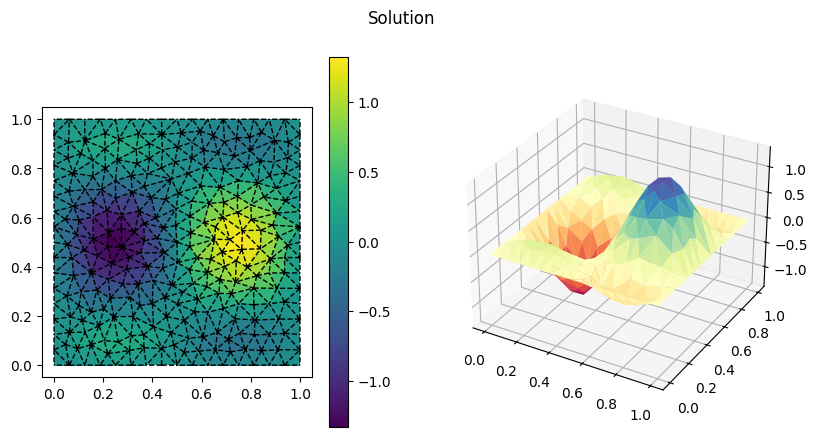

In [24]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)

gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

**NB**: We'll use the so obtained snapshots to solve the problem with Proper orthogonal decomposition (POD)

## 1.2 POD of NEP1

It is not necessary to use the supremizer because the problem under consideration is a scalar elliptic equation and has no saddle-point structure or incompressibility constraints. In the absence of a pressure variable and the inf-sup condition, enrichment with a supremizer is not required.

#### Covariance matrix and change of basis matrix

In [25]:
# We assemble here the linear system
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
inner_product = stiffness 

# Definitio of the covariance matrix
C = snapshots_matrix @ inner_product @ np.transpose(snapshots_matrix) 

After assembling the covariance matrix by means of the snapshot matrix obtained solving the high fidelity problem for a finite number $N_{\delta} < +\infty$ of parameters, we implement the POD method. We solve the eigenvalue problem and find the number $N\leq N_{\delta}$ of basis vectors needed to keep a large enough percentage of relative retained energy (ie enough information)

In [26]:
# Eigenvalue problem

tol = 1. - 1e-7

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.) # We need a symmetic positive definite matrix: all eigenvalues real and positive
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues) # Sum of all the eigenvalues
retained_energy_vector = np.cumsum(eigenvalues) # Cumulative sum (summing until n)
relative_retained_energy = retained_energy_vector/total_energy # "Percentage"

# The IDEA is: we have a tol = 1 - 1e-7, the first time that relative_retained_energy 
# (that is the sum of the eigenvalue) is
# bigger than the tol, I can stop the computation and study the problem in 
# that number of dimenison
# Hence, all the other eigenvalue (and so direction) are NOT relevant to 
# compute the solution

# We want the first term for that the relative_retained_energy is less then 1 - 1e-7
if all(flag==False for flag in relative_retained_energy>= tol): 
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1 # Python works from 0, but the basis goes from 1

# I need 3 basis (see the resutl) to show everything, this means that with 3 
# eigenvalues we reach the condition, and all the other are very very small (irrelevant)
print("The reduced dimension is N =", N) 

The reduced dimension is N = 3


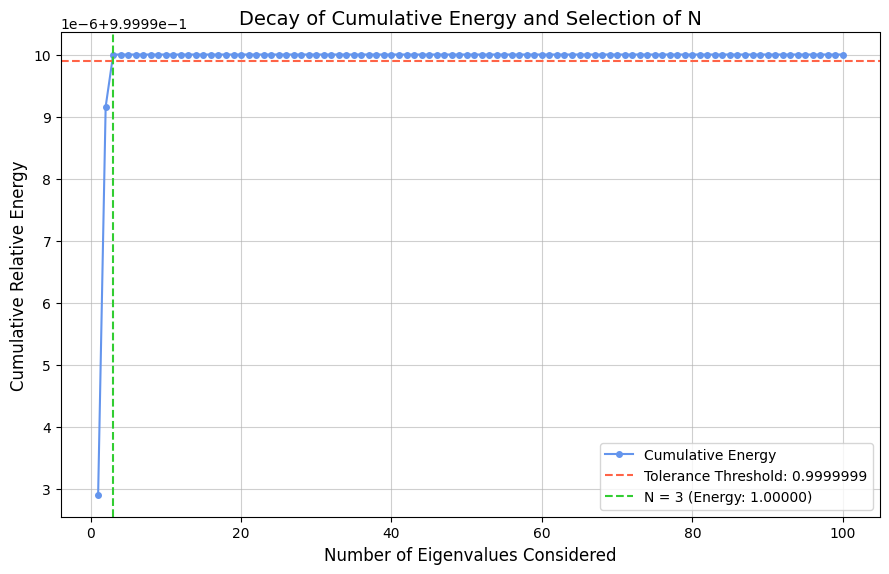

In [27]:
N = 3

plt.figure(figsize=(9, 6)) # Slightly larger figure for better readability

# Plot the cumulative energy
# Using a slightly darker pastel blue and smaller marker for a cleaner look
plt.plot(range(1, len(relative_retained_energy) + 1), relative_retained_energy,
         marker='o', markersize=4, linestyle='-', color='#6495ED', # CornflowerBlue
         label='Cumulative Energy')

# Horizontal line for the tolerance threshold
plt.axhline(y=tol, color='#FF6347', linestyle='--', linewidth=1.5, # Tomato
            label=f'Tolerance Threshold: {tol:.7f}')

# Vertical line for N
# Get the value of cumulative energy at N
if 1 <= N <= len(relative_retained_energy):
    energy_at_N = relative_retained_energy[N - 1]
    # Format the energy value to be readable (e.g., 5 decimal places or scientific notation if very small)
    formatted_energy_at_N = f'{energy_at_N:.5f}' if energy_at_N > 0.001 else f'{energy_at_N:.2e}'
    plt.axvline(x=N, color='#32CD32', linestyle='--', linewidth=1.5, # LimeGreen
                label=f'N = {N} (Energy: {formatted_energy_at_N})') # Added formatted energy value to label
else:
    plt.axvline(x=N, color='#32CD32', linestyle='--', linewidth=1.5, # LimeGreen
                label=f'N = {N}') # Fallback if N is out of bounds

# Customize labels and title with slightly larger fonts for better visibility
plt.xlabel('Number of Eigenvalues Considered', fontsize=12)
plt.ylabel('Cumulative Relative Energy', fontsize=12)
plt.title('Decay of Cumulative Energy and Selection of N', fontsize=14)

# Add grid lines for better readability
plt.grid(True, which="both", ls="-", alpha=0.6) # Solid grid lines, slightly transparent

plt.legend(loc='lower right', fontsize=10) # Position legend for better fit
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

Use the $N=3$ eigenvalues and use the corresponding eigenvectors to build an $N$-dimensional basis for $V_N$. Based on the plot, $N=3$ is chosen because the "Cumulative Energy" (blue line) reaches $1.00000$, meeting or exceeding the "Tolerance Threshold" of $0.9999999$. This indicates that by considering only three eigenvalues, essentially all relevant energy is captured. Selecting $N=3$ therefore provides the most efficient dimensionality reduction without sacrificing accuracy.

**NB**: the change of basis matrix has dimensions  $ \mathbb{B}\in \mathbb{R}^{N_{\delta} \times N}$

#### Offline phase 
Assemble the terms that do not depend on the parameters (do io once and for all) and project them in the reduced space using the change of basis matrix.


In [28]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  # basis = (1/np.sqrt(snapshot_num))*np.transpose(snapshot_matrix)@eigenvector  
  # (This is the one of the book!!)
  
  basis = np.transpose(snapshots_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) # ||u||_H^1 = u'Xu 
  
  basis /= norm # Normalizing
  basis_functions.append(np.copy(basis)) # Have all together all the basis

basis_functions = np.transpose(np.array(basis_functions))

In [29]:
# ASSEMBLE THE LINEAR SYSTEM OFFLINE
# Reduce operator
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
reduced_stiff = np.transpose(basis_functions) @ stiffness @ basis_functions

# Assemble the forcing term (all the right part of the equation)
forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # NO PARAMETRI
forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib) # NO PARAMETRI

reduced_forcingTerm_g =  np.transpose(basis_functions) @ forcingTerm_g
reduced_forcingTerm_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v 

### OFFLINE STOP

#### Online phase 
To compute the POD approximation of the solution for a given $\mu$:
1) Choose a vector of parameters $\mu=(\mu_0, \mu_1)$
2) Assemble the terms that depend on the parameters and project them in the reduced space
3) Solve the ROM linear system (N-dimensional) for the solution
4) Project the solution back in the FOM space ($N_{\delta}$-dimensional)

In [30]:
### ONLINE START
# 1)
# mu_0:  0.3544776894466156 mu_1:  0.5238513217014148
mu_0 = 0.2
mu_1 = 0.8

# 2)
# Assemble reaction online
[reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib) # Sì PARAMETRI
reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # Projection

# Assemble forcing term online
forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib) # Sì PARAMETRI
reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v 

reduced_lhs = reduced_stiff + reduced_react
reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v

In [31]:
# 3)
reduced_solution = np.linalg.solve(reduced_lhs, reduced_rhs)
print(reduced_solution)

[-0.97551895 11.71739101 10.72613471]


In [32]:
# 4)
# I need to project reduced_solution back to the finite element space (calligraphic N)
proj_reduced_solution = basis_functions @ reduced_solution 

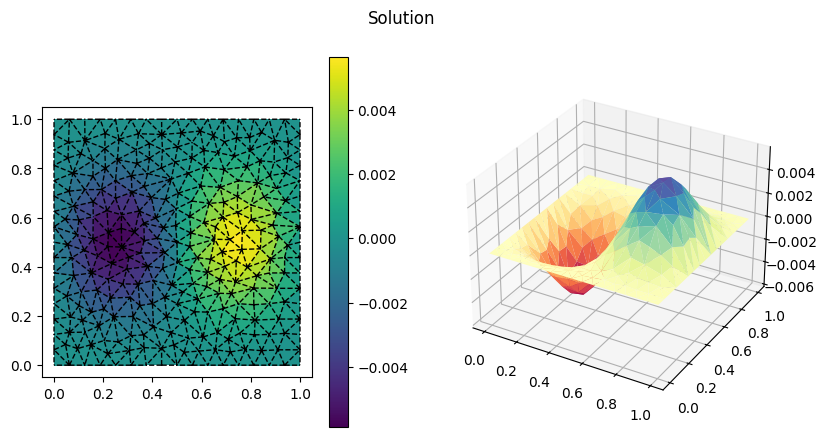

In [33]:
# plot the reduce solution projected
gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, np.zeros(problemData['NumberStrongs'])) 
#gedim.ExportSolution(Elliptic_exactSolution, u_k, u_strong, lib) CAPIRE COME E SE ESPORTARLA

## Error computation of POD
To evaluate the goodness of the POD solution, we measure the reconstruction error of projecting the reduced solution in the full space wrt the solution computed in the full space. The **absolute error** is
$$
E^{POD}_{abs} = (u_{fom} - u_{rom} )^T\mathbb{X} (u_{fom} - u_{rom} ) = ||u_{fom} - u_{rom}||^2_{L^2}
$$
where $ \mathbb{X} $ is the inner product matrix and $u_{rom} = \mathbb{B} u_N$. We compute it doing
`
error_function_u = fom_solution - rom_solution_FE_basis
error_norm_squared_component = np.transpose(error_function_u) @ inner_product_matrix @ error_function_u
absolute_error = np.sqrt(abs(error_norm_squared_component))
`

The **relative error** is 
$$
E^{POD}_{rel} = \frac{(u_{fom} - u_{rom} )^T\mathbb{X} (u_{fom} - u_{rom} )}{u_{fom}^T \mathbb{X} u_{fom}} = \frac{ ||u_{fom} - u_{rom}||^2_{L^2} }{ ||u_{fom}||^2_{L^2}}
$$
We compute it doing
`
full_solution_norm_squared_component = np.transpose(fom_solution) @  inner_product_matrix @ fom_solution
relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
`

We also evaluate the performance of the POD solution in terms of computational time. To do so, we compute the **speed up** rate between the full and the reduced solution of the problem on the same "test set" of parameters.

In [34]:
# Compute the error for the solution, we want to compute separate error for velocity and for pressure
def compute_error(fom_solution, rom_solution_FE_basis, inner_product=None, type_err="relative"):
    
    error_function_u = fom_solution - rom_solution_FE_basis
    
    if inner_product == None:
      inner_product_matrix = np.identity(fom_solution.shape[0])
    else:
      inner_product_matrix = inner_product
    
    error_norm_squared_component = np.transpose(error_function_u) @ inner_product_matrix @ error_function_u
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    
    if type_err == "absolute":
      return absolute_error
    
    else:
      full_solution_norm_squared_component = np.transpose(fom_solution) @  inner_product_matrix @ fom_solution
      relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    
      return relative_error

In [35]:
abs_err_u = []
rel_err_u = []

testing_set = np.random.uniform(low=0.1, high=1, size=(100, 2))
speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
    mu_0 = mu[0]
    mu_1 = mu[1]
    
    # FULL
    start_time_assemble = time.time()
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
    time_assemble = time.time() - start_time_assemble

    lhs = stiffness + reaction
    rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
    
    start_fom = time.time()
    full_solution = gedim.LUSolver(lhs, rhs, lib)
    time_fom = time.time() - start_fom
    
    # REDUCED 
    reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v # mu_0, mu_1 dipendent
    reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # mu_0, mu_1 dipendent
    
    reduced_lhs = reduced_stiff + reduced_react
    reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v
    
    start_rom = time.time()
    reduced_solution = np.linalg.solve(reduced_lhs, reduced_rhs)
    time_rom = time.time() - start_rom
    
    speed_up.append((time_fom)/(time_rom))
    
    reduced_solution_FE_basis = basis_functions @ reduced_solution
    
    ### computing error
    
    abs_err_u_mu = compute_error(full_solution, reduced_solution_FE_basis, inner_product=inner_product, type_err="absolute")
    rel_err_u_mu = compute_error(full_solution, reduced_solution_FE_basis, inner_product=inner_product)
    abs_err_u.append(abs_err_u_mu)
    rel_err_u.append(rel_err_u_mu)

Computing error and speedup analysis


In [36]:
print("avarege relative error = ", np.mean(rel_err_u) )
print("avarege absolute error = ", np.mean(abs_err_u) )

print("avarege speed_up = ", np.mean(speed_up) )

print()

print(f"time_assemble: {time_assemble}")
print(f"time_fom: {time_fom}")
print(f"time_rom: {time_rom}")

avarege relative error =  0.02197768183699496
avarege absolute error =  0.0003774163852728451
avarege speed_up =  24.247697169792886

time_assemble: 0.02428126335144043
time_fom: 0.0012385845184326172
time_rom: 0.00013875961303710938


**Interpretation of the POD:** Proper Orthogonal Decomposition (POD) allows the extraction of the main directions of variation of the solution in parameter space. The first $r$ modes $\phi_i$ explain most of the energy of the system, allowing an effective reduction of the dimensionality of the problem. The cumulative value of the eigenvalues provides an estimate of the percentage of information retained.

# 2. PINN

In [35]:
# Change 40 with 80 (or nuber between them)
# Other activation functions: Sin or Sigmoid

class PINN40(nn.Module):
    def __init__(self):
        super(PINN40, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )

    def forward(self, x, mu):
        input = torch.cat((x, mu), dim=1)  # x.shape = [batch, 2], mu.shape = [batch, 2]
        return self.net(input)

In [37]:
# Change 40 with 80 (or nuber between them)
# Other activation functions: Sin or Sigmoid

class PINN60(nn.Module):
    def __init__(self):
        super(PINN60, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 60),
            nn.Tanh(),
            nn.Linear(60, 60),
            nn.Tanh(),
            nn.Linear(60, 60),
            nn.Tanh(),
            nn.Linear(60, 60),
            nn.Tanh(),
            nn.Linear(60, 1)
        )

    def forward(self, x, mu):
        input = torch.cat((x, mu), dim=1)  # x.shape = [batch, 2], mu.shape = [batch, 2]
        return self.net(input)

In [38]:
# Change 40 with 80 (or nuber between them)
# Other activation functions: Sin or Sigmoid

class PINN80(nn.Module):
    def __init__(self):
        super(PINN80, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 80),
            nn.Tanh(),
            nn.Linear(80, 80),
            nn.Tanh(),
            nn.Linear(80, 80),
            nn.Tanh(),
            nn.Linear(80, 80),
            nn.Tanh(),
            nn.Linear(80, 1)
        )

    def forward(self, x, mu):
        input = torch.cat((x, mu), dim=1)  # x.shape = [batch, 2], mu.shape = [batch, 2]
        return self.net(input)

In [46]:
def generate_data(N_domain=1000, N_boundary=200):
    # Points in the domain
    x_in = torch.rand((N_domain, 2))  # [x0, x1] ∈ Ω
    mu_in = (torch.rand((1, 2)) * 0.9 + 0.1).expand(N_domain, -1) # [mu0, mu1] ∈ [0.1, 1]^2

    # Points on the border of the domain (edge of the square)
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)

    xb = torch.cat([
        torch.cat([x0, zeros], dim=1),
        torch.cat([x0, ones], dim=1),
        torch.cat([zeros, x0], dim=1),
        torch.cat([ones, x0], dim=1)
    ], dim=0)

    mu_b = mu_in[:N_boundary*4, :]
    return x_in, mu_in, xb, mu_b

In [39]:
# Fr decrescere lambda per migliorare -->fare prove con diversi valori di lambda tra 0 e 1 e vedere come va meglio,
#ma fissarlo una volta per tuttte fuori, non farlo decrescere nel training
# Change optimizer

def train_exact_sol(model_no_change_opt, epochs=50000, lr=1e-3, lambda_bc=1.0):
    model = model_no_change_opt
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    #sample_mu = torch.rand((epochs, 2)) * 0.9 + 0.1 # Uniform sampling in mu_Rang of 100 samples

    for epoch in range(epochs):
        x_in, mu, xb, mu_b = generate_data()
        
        model.train()
        optimizer.zero_grad()

        # Loss fisica (residuo PDE)
        loss_phys = mse_loss(R_exact_sol(x_in, mu, model), torch.zeros_like(x_in[:, :1]))

        # Loss al bordo (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Loss totale
        loss_total = loss_phys + lambda_bc * loss_bc
        loss_total.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

############################# IN ALTERNATIVE ##########################
def train_change_opt_exact_sol(model, epochs=50000, lr=1e-3, lambda_bc=1.0):
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    using_lbfgs = False  # flag per sapere quale ottimizzatore è attivo

    for epoch in range(epochs):
        x_in, mu_in, xb, mu_b = generate_data()


        if not using_lbfgs:
            # === Fase ADAM ===
            model.train()
            optimizer.zero_grad()

            loss_phys = mse_loss(R_exact_sol(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
            u_b = model(xb, mu_b)
            loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

            loss_total = loss_phys + lambda_bc * loss_bc
            loss_total.backward()
            optimizer.step()

            # Verifica se entrambe le loss sono ≤ 1e-2 per passare a LBFGS
            if loss_bc.item() < 1e-1 and loss_phys.item() < 1e-1:
                using_lbfgs = True
                optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)

        else:
            # === Fase LBFGS ===
            def closure():
                optimizer.zero_grad()
                loss_phys = mse_loss(R_exact_sol(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc
                loss_total.backward()
                return loss_total

            optimizer.step(closure)

            # Ricalcola le loss per logging
            loss_phys = mse_loss(R_exact_sol(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
            u_b = model(xb, mu_b)
            loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
            loss_total = loss_phys + lambda_bc * loss_bc

        # Logging ogni 500 epoche
        if epoch % 500 == 0:
            opt_name = "LBFGS" if using_lbfgs else "Adam"
            print(f"[{opt_name}] Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

In [44]:
# OPTIONS FOR THE OPTIMIZER
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # Change LBFGS when the loss does not decrease 

# For LNFGS
# optim.LBFGS(net.parameters(), lr=1, max_iter=500000)
# torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1000, gamma=0.5) # To reduce il lr during the training for LBFGS
# at each epoch call lr_scheduler.StepLR 

In [40]:
def val_exact_sol(model, epochs=10, lambda_bc=1.0):
   
    mse_loss = nn.MSELoss()
    loss_bc = 1
    loss_phys = 1 

    for epoch in range(epochs):   
             
        x_in, mu_in, xb, mu_b = generate_data()
        
        model.eval()

        # Phiycial Loss (residual PDE)
        loss_phys = mse_loss(R_exact_sol(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))

        # Boundary Loss (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Total Loss 
        loss_total = loss_phys + lambda_bc * loss_bc

        print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

## 2.0 PINN PRELIMINARY ANALYSIS

Recall the forcing term of the exact solution problem : 
 $$\tilde{g}(x,y;\mu) = 2 \mu_0 (y(1-y) + x(1-x)) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \mu_0xy(1-x)(1-y)} - 1) $$

In [40]:
# Residual for the exact solution problem
def R_exact_sol(x, mu, net):
    x.requires_grad_(True)
    #mu.requires_grad_(False)
    
    u = net(x, mu)  # output shape: [N, 1]

    # Calcola gradiente ∇u (cioè du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Calcola secondo ordine: Laplaciano = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g_exact = 2 * mu0 * ( x1 * (1-x1) + x0 * (1-x0) ) + (mu0/mu1) * (torch.exp(mu1 * mu0 * x0 * x1 * (1-x0) * (1-x1)) -1 )

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g_exact

    return residual

In [47]:
# create the model 
exact_sol_model = PINN40() # Call the function that we have just implemented
train_exact_sol(exact_sol_model, epochs= 10000)

Epoch 0 - Loss: 3.815520e-01  [PDE: 3.81e-01, BC: 2.52e-04]
Epoch 500 - Loss: 5.603911e-04  [PDE: 2.74e-04, BC: 2.86e-04]
Epoch 1000 - Loss: 4.680033e-04  [PDE: 3.50e-04, BC: 1.18e-04]
Epoch 1500 - Loss: 1.295703e-03  [PDE: 1.14e-03, BC: 1.55e-04]
Epoch 2000 - Loss: 2.884930e-03  [PDE: 2.46e-03, BC: 4.20e-04]
Epoch 2500 - Loss: 9.960469e-04  [PDE: 8.89e-04, BC: 1.07e-04]
Epoch 3000 - Loss: 2.332175e-03  [PDE: 1.92e-03, BC: 4.08e-04]
Epoch 3500 - Loss: 3.501980e-04  [PDE: 2.92e-04, BC: 5.78e-05]
Epoch 4000 - Loss: 9.524864e-04  [PDE: 7.31e-04, BC: 2.21e-04]
Epoch 4500 - Loss: 1.360090e-04  [PDE: 1.11e-04, BC: 2.52e-05]
Epoch 5000 - Loss: 7.863451e-04  [PDE: 6.37e-04, BC: 1.50e-04]
Epoch 5500 - Loss: 2.238587e-04  [PDE: 1.66e-04, BC: 5.78e-05]
Epoch 6000 - Loss: 4.343195e-04  [PDE: 3.25e-04, BC: 1.09e-04]
Epoch 6500 - Loss: 1.909890e-04  [PDE: 1.50e-04, BC: 4.15e-05]
Epoch 7000 - Loss: 3.128705e-04  [PDE: 2.42e-04, BC: 7.06e-05]
Epoch 7500 - Loss: 3.101044e-04  [PDE: 2.18e-04, BC: 9.20e-

In [77]:
val(exact_sol_model)

Epoch 0 - Loss: 3.360016e-01  [PDE: 2.24e-01, BC: 1.12e-01]
Epoch 1 - Loss: 3.342029e-01  [PDE: 2.23e-01, BC: 1.11e-01]
Epoch 2 - Loss: 3.350413e-01  [PDE: 2.20e-01, BC: 1.15e-01]
Epoch 3 - Loss: 3.672534e-01  [PDE: 2.49e-01, BC: 1.18e-01]
Epoch 4 - Loss: 3.367751e-01  [PDE: 2.25e-01, BC: 1.12e-01]
Epoch 5 - Loss: 3.374012e-01  [PDE: 2.26e-01, BC: 1.12e-01]
Epoch 6 - Loss: 3.274961e-01  [PDE: 2.18e-01, BC: 1.10e-01]
Epoch 7 - Loss: 3.495892e-01  [PDE: 2.28e-01, BC: 1.21e-01]
Epoch 8 - Loss: 3.397263e-01  [PDE: 2.21e-01, BC: 1.18e-01]
Epoch 9 - Loss: 3.223135e-01  [PDE: 2.08e-01, BC: 1.14e-01]


In [66]:
val(exact_sol_model, epochs = 20)

Epoch 0 - Loss: 2.463197e+03  [PDE: 2.46e+03, BC: 6.03e-07]
Epoch 1 - Loss: 2.477790e+03  [PDE: 2.48e+03, BC: 5.85e-07]
Epoch 2 - Loss: 2.425416e+03  [PDE: 2.43e+03, BC: 5.62e-07]
Epoch 3 - Loss: 2.470085e+03  [PDE: 2.47e+03, BC: 6.11e-07]
Epoch 4 - Loss: 2.302222e+03  [PDE: 2.30e+03, BC: 5.75e-07]
Epoch 5 - Loss: 2.564430e+03  [PDE: 2.56e+03, BC: 5.65e-07]
Epoch 6 - Loss: 2.629664e+03  [PDE: 2.63e+03, BC: 5.84e-07]
Epoch 7 - Loss: 2.559152e+03  [PDE: 2.56e+03, BC: 5.83e-07]
Epoch 8 - Loss: 2.556138e+03  [PDE: 2.56e+03, BC: 6.24e-07]
Epoch 9 - Loss: 2.443463e+03  [PDE: 2.44e+03, BC: 5.95e-07]
Epoch 10 - Loss: 2.463646e+03  [PDE: 2.46e+03, BC: 5.76e-07]
Epoch 11 - Loss: 2.418667e+03  [PDE: 2.42e+03, BC: 6.05e-07]
Epoch 12 - Loss: 2.461867e+03  [PDE: 2.46e+03, BC: 5.92e-07]
Epoch 13 - Loss: 2.595803e+03  [PDE: 2.60e+03, BC: 6.06e-07]
Epoch 14 - Loss: 2.553272e+03  [PDE: 2.55e+03, BC: 5.30e-07]
Epoch 15 - Loss: 2.418699e+03  [PDE: 2.42e+03, BC: 6.12e-07]
Epoch 16 - Loss: 2.626840e+03  [PD

In [ ]:
## PROVA CON GRAD = FALSE

In [44]:
def generate_data(N_domain=1000, N_boundary=100):
    # Points in the domain
    x_in = torch.rand((N_domain, 2))  # [x0, x1] ∈ Ω
    mu_in = torch.rand((N_domain, 2)) * 0.9 + 0.1  # [mu0, mu1] ∈ [0.1, 1]^2

    # Points on the border of the domain (edge of the square)
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)

    xb = torch.cat([
        torch.cat([x0, zeros], dim=1),
        torch.cat([x0, ones], dim=1),
        torch.cat([zeros, x0], dim=1),
        torch.cat([ones, x0], dim=1)
    ], dim=0)

    mu_b = torch.rand((xb.shape[0], 2)) * 0.9 + 0.1
    return x_in, mu_in, xb, mu_b

In [49]:
def train_exact_sol(model_no_change_opt, epochs=50000, lr=1e-3, lambda_bc=1.0):
    model = model_no_change_opt
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        x_in, mu_in, xb, mu_b = generate_data()
        
        model.train()
        optimizer.zero_grad()

        # Loss fisica (residuo PDE)
        loss_phys = mse_loss(R_exact_sol(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))

        # Loss al bordo (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Loss totale
        loss_total = loss_phys + lambda_bc * loss_bc
        loss_total.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")


In [50]:
# Residual for the exact solution problem
def R_exact_sol(x, mu, net):
    x.requires_grad_(True)
    mu.requires_grad_(False)

    u = net(x, mu)  # output shape: [N, 1]

    # Calcola gradiente ∇u (cioè du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Calcola secondo ordine: Laplaciano = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g_exact = 2 * mu0 * ( x1 * (1-x1) + x0 * (1-x0) ) + (m0/m1) * (torch.exp(mu1 * u) -1 )

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g_exact

    return residual

In [51]:
# create the model 
exact_sol_model = PINN40() # Call the function that we have just implemented
train(exact_sol_model, epochs= 10000)

Epoch 0 - Loss: 2.371877e+03  [PDE: 2.37e+03, BC: 9.32e-03]
Epoch 500 - Loss: 2.436732e+01  [PDE: 1.58e+01, BC: 8.61e+00]
Epoch 1000 - Loss: 7.282376e+00  [PDE: 2.55e+00, BC: 4.74e+00]
Epoch 1500 - Loss: 4.147568e+00  [PDE: 1.17e+00, BC: 2.98e+00]
Epoch 2000 - Loss: 2.564164e+00  [PDE: 5.99e-01, BC: 1.96e+00]
Epoch 2500 - Loss: 1.824682e+00  [PDE: 3.72e-01, BC: 1.45e+00]
Epoch 3000 - Loss: 1.676300e+00  [PDE: 3.78e-01, BC: 1.30e+00]
Epoch 3500 - Loss: 1.450175e+00  [PDE: 2.98e-01, BC: 1.15e+00]
Epoch 4000 - Loss: 1.266775e+00  [PDE: 3.09e-01, BC: 9.58e-01]
Epoch 4500 - Loss: 1.011481e+00  [PDE: 1.71e-01, BC: 8.40e-01]
Epoch 5000 - Loss: 1.003024e+00  [PDE: 2.88e-01, BC: 7.15e-01]
Epoch 5500 - Loss: 8.061375e-01  [PDE: 1.94e-01, BC: 6.12e-01]
Epoch 6000 - Loss: 7.912523e-01  [PDE: 3.18e-01, BC: 4.73e-01]
Epoch 6500 - Loss: 5.760915e-01  [PDE: 1.78e-01, BC: 3.98e-01]
Epoch 7000 - Loss: 4.339351e-01  [PDE: 1.24e-01, BC: 3.10e-01]
Epoch 7500 - Loss: 4.229320e-01  [PDE: 1.79e-01, BC: 2.44e-

In [52]:
# create the model 
exact_sol_model = PINN60() # Call the function that we have just implemented
train(exact_sol_model, epochs= 10000)

Epoch 0 - Loss: 2.572280e+03  [PDE: 2.57e+03, BC: 1.16e-02]
Epoch 500 - Loss: 2.397347e+01  [PDE: 1.76e+01, BC: 6.38e+00]
Epoch 1000 - Loss: 5.462039e+00  [PDE: 2.71e+00, BC: 2.75e+00]
Epoch 1500 - Loss: 1.836392e+00  [PDE: 6.98e-01, BC: 1.14e+00]
Epoch 2000 - Loss: 1.116464e+00  [PDE: 4.10e-01, BC: 7.07e-01]
Epoch 2500 - Loss: 1.121223e+00  [PDE: 5.78e-01, BC: 5.44e-01]
Epoch 3000 - Loss: 9.743775e-01  [PDE: 5.65e-01, BC: 4.10e-01]
Epoch 3500 - Loss: 4.730219e-01  [PDE: 1.92e-01, BC: 2.81e-01]
Epoch 4000 - Loss: 4.432545e-01  [PDE: 1.98e-01, BC: 2.46e-01]
Epoch 4500 - Loss: 3.356425e-01  [PDE: 1.56e-01, BC: 1.80e-01]
Epoch 5000 - Loss: 5.787234e+00  [PDE: 5.65e+00, BC: 1.42e-01]
Epoch 5500 - Loss: 4.368449e-01  [PDE: 3.10e-01, BC: 1.26e-01]
Epoch 6000 - Loss: 6.254810e-01  [PDE: 5.12e-01, BC: 1.13e-01]
Epoch 6500 - Loss: 2.096322e-01  [PDE: 1.15e-01, BC: 9.51e-02]
Epoch 7000 - Loss: 3.015672e-01  [PDE: 2.03e-01, BC: 9.82e-02]
Epoch 7500 - Loss: 6.051735e-01  [PDE: 5.23e-01, BC: 8.20e-

In [53]:
# create the model 
exact_sol_model = PINN80() # Call the function that we have just implemented
train(exact_sol_model, epochs= 10000)

Epoch 0 - Loss: 2.378313e+03  [PDE: 2.38e+03, BC: 1.68e-03]
Epoch 500 - Loss: 6.085830e+00  [PDE: 2.87e+00, BC: 3.22e+00]
Epoch 1000 - Loss: 1.869568e+00  [PDE: 6.37e-01, BC: 1.23e+00]
Epoch 1500 - Loss: 1.547891e+00  [PDE: 5.65e-01, BC: 9.83e-01]
Epoch 2000 - Loss: 1.010696e+00  [PDE: 2.73e-01, BC: 7.38e-01]
Epoch 2500 - Loss: 9.048212e-01  [PDE: 2.83e-01, BC: 6.22e-01]
Epoch 3000 - Loss: 1.095554e+00  [PDE: 6.74e-01, BC: 4.21e-01]
Epoch 3500 - Loss: 5.989765e-01  [PDE: 3.07e-01, BC: 2.92e-01]
Epoch 4000 - Loss: 4.655141e-01  [PDE: 2.71e-01, BC: 1.94e-01]
Epoch 4500 - Loss: 2.796879e-01  [PDE: 1.41e-01, BC: 1.39e-01]
Epoch 5000 - Loss: 3.412223e-01  [PDE: 2.36e-01, BC: 1.05e-01]
Epoch 5500 - Loss: 3.089920e-01  [PDE: 2.23e-01, BC: 8.58e-02]
Epoch 6000 - Loss: 1.790783e-01  [PDE: 1.09e-01, BC: 6.97e-02]
Epoch 6500 - Loss: 2.223469e-01  [PDE: 1.56e-01, BC: 6.60e-02]
Epoch 7000 - Loss: 5.228383e-01  [PDE: 4.69e-01, BC: 5.43e-02]
Epoch 7500 - Loss: 2.140346e-01  [PDE: 1.64e-01, BC: 5.00e-

## 2.1 PINN ON NEP1

In [41]:
# x: [N, 2], mu: [N, 2]
def R(x, mu, net):
    x.requires_grad_(True)
    mu.requires_grad_(False)

    u = net(x, mu)  # output shape: [N, 1]

    # Calcola gradiente ∇u (cioè du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Calcola secondo ordine: Laplaciano = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g = 100 * torch.sin(2 * torch.pi * x0) * torch.cos(2 * torch.pi * x1)

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g

    return residual

In [42]:
# Fr decrescere lambda per migliorare -->fare prove con diversi valori di lambda tra 0 e 1 e vedere come va meglio,
#ma fissarlo una volta per tuttte fuori, non farlo decrescere nel training
# Change optimizer

def train(model_no_change_opt, epochs=100000, lr=1e-3, lambda_bc=1.0):
    model = model_no_change_opt
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        x_in, mu_in, xb, mu_b = generate_data()
        
        model.train()
        optimizer.zero_grad()

        # Loss fisica (residuo PDE)
        loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))

        # Loss al bordo (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Loss totale
        loss_total = loss_phys + lambda_bc * loss_bc
        loss_total.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

############################# IN ALTERNATIVE ##########################
def train_change_opt(model, epochs=50000, lr=1e-3, lambda_bc=1.0):
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    using_lbfgs = False  # flag per sapere quale ottimizzatore è attivo

    for epoch in range(epochs):
        x_in, mu_in, xb, mu_b = generate_data()

        if not using_lbfgs:
            # === Fase ADAM ===
            model.train()
            optimizer.zero_grad()

            loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
            u_b = model(xb, mu_b)
            loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

            loss_total = loss_phys + lambda_bc * loss_bc
            loss_total.backward()
            optimizer.step()

            # Verifica se entrambe le loss sono ≤ 1e-2 per passare a LBFGS
            if loss_bc.item() < 1e-1 and loss_phys.item() < 1e-1:
                using_lbfgs = True
                optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)

        else:
            # === Fase LBFGS ===
            def closure():
                optimizer.zero_grad()
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc
                loss_total.backward()
                return loss_total

            optimizer.step(closure)

            # Ricalcola le loss per logging
            loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
            u_b = model(xb, mu_b)
            loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
            loss_total = loss_phys + lambda_bc * loss_bc

        # Logging ogni 500 epoche
        if epoch % 500 == 0:
            opt_name = "LBFGS" if using_lbfgs else "Adam"
            print(f"[{opt_name}] Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

In [52]:
def train_plot(model_no_change_opt, epochs=100000, lr=1e-3, lambda_bc=1.0):
    model = model_no_change_opt
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    loss_history = []
    epoch_times = []

    for epoch in range(epochs):
        epoch_start = time.time()  # Start timer

        x_in, mu_in, xb, mu_b = generate_data()
        
        model.train()
        optimizer.zero_grad()

        # Loss fisica (residuo PDE)
        loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))

        # Loss al bordo (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Loss totale
        loss_total = loss_phys + lambda_bc * loss_bc
        loss_total.backward()
        optimizer.step()

        # Save loss and time
        loss_history.append(loss_total.item())
        epoch_times.append(time.time() - epoch_start)

        if epoch % 500 == 0:
            print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

    # Tempo medio
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"\n⏱ Mean time for epoch: {avg_epoch_time:.4f} secondi")

    # Plot loss in scala logaritmica
    plt.figure(figsize=(10, 4))
    plt.plot(loss_history, label="Total Loss", color="steelblue", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss (log scale)", fontsize=12)
    plt.title("Training Loss vs Epochs (Log Scale)", fontsize=14)
    plt.yscale("log")  # <-- Scala logaritmica qui
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Plot tempo per epoca
    plt.figure(figsize=(10, 4))
    plt.plot(epoch_times, label="Time for epoch (s)", color="darkorange", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Time (s)", fontsize=12)
    plt.title("Execution time for epoch", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return loss_history, epoch_times

Epoch 0 - Loss: 2.609591e+03  [PDE: 2.61e+03, BC: 2.03e-02]
Epoch 500 - Loss: 1.842321e+02  [PDE: 1.75e+02, BC: 8.75e+00]
Epoch 1000 - Loss: 8.125621e+00  [PDE: 4.00e+00, BC: 4.13e+00]
Epoch 1500 - Loss: 4.561657e+00  [PDE: 2.19e+00, BC: 2.37e+00]
Epoch 2000 - Loss: 2.856038e+00  [PDE: 1.41e+00, BC: 1.45e+00]
Epoch 2500 - Loss: 1.796807e+00  [PDE: 6.53e-01, BC: 1.14e+00]
Epoch 3000 - Loss: 1.586930e+00  [PDE: 6.15e-01, BC: 9.71e-01]
Epoch 3500 - Loss: 1.260175e+00  [PDE: 4.13e-01, BC: 8.47e-01]
Epoch 4000 - Loss: 1.005206e+00  [PDE: 3.39e-01, BC: 6.66e-01]
Epoch 4500 - Loss: 7.109178e-01  [PDE: 2.39e-01, BC: 4.72e-01]
Epoch 5000 - Loss: 5.809458e-01  [PDE: 2.44e-01, BC: 3.37e-01]
Epoch 5500 - Loss: 5.190469e-01  [PDE: 2.21e-01, BC: 2.98e-01]
Epoch 6000 - Loss: 6.022522e-01  [PDE: 3.64e-01, BC: 2.39e-01]
Epoch 6500 - Loss: 4.280999e-01  [PDE: 2.36e-01, BC: 1.92e-01]
Epoch 7000 - Loss: 3.684640e-01  [PDE: 2.29e-01, BC: 1.40e-01]
Epoch 7500 - Loss: 2.760346e-01  [PDE: 1.59e-01, BC: 1.17e-

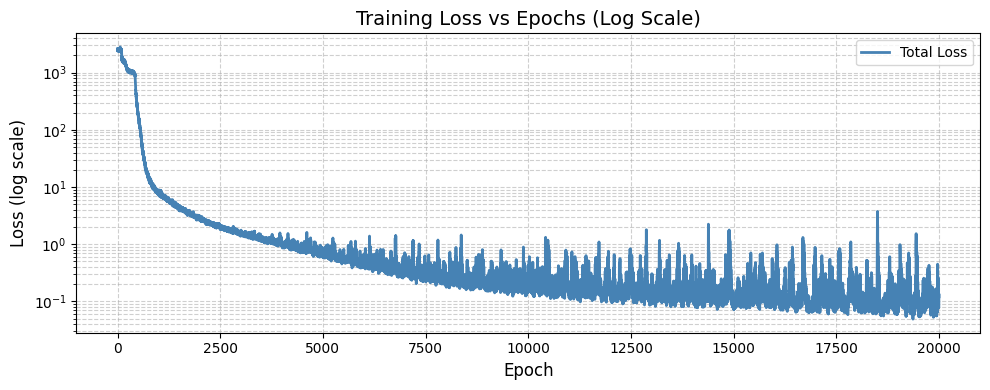

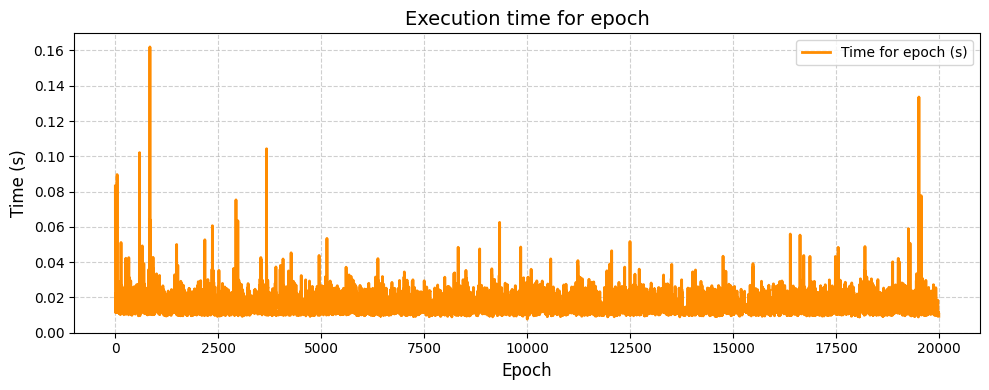

In [53]:
model_no_change_opt = PINN40()
train_plot(model_no_change_opt, epochs = 20000)

torch.save(model_no_change_opt.state_dict(), "PINN40.pth")

Epoch 0 - Loss: 2.416533e+03  [PDE: 2.42e+03, BC: 2.88e-03]
Epoch 500 - Loss: 1.131290e+01  [PDE: 3.69e+00, BC: 7.62e+00]
Epoch 1000 - Loss: 3.966054e+00  [PDE: 1.05e+00, BC: 2.92e+00]
Epoch 1500 - Loss: 1.966810e+00  [PDE: 3.73e-01, BC: 1.59e+00]
Epoch 2000 - Loss: 1.791455e+00  [PDE: 4.33e-01, BC: 1.36e+00]
Epoch 2500 - Loss: 1.426757e+00  [PDE: 2.14e-01, BC: 1.21e+00]
Epoch 3000 - Loss: 1.292166e+00  [PDE: 3.05e-01, BC: 9.87e-01]
Epoch 3500 - Loss: 1.367599e+00  [PDE: 5.05e-01, BC: 8.62e-01]
Epoch 4000 - Loss: 9.629956e-01  [PDE: 2.17e-01, BC: 7.46e-01]
Epoch 4500 - Loss: 8.140776e-01  [PDE: 1.83e-01, BC: 6.31e-01]
Epoch 5000 - Loss: 6.215448e-01  [PDE: 1.34e-01, BC: 4.88e-01]
Epoch 5500 - Loss: 5.526947e-01  [PDE: 1.55e-01, BC: 3.98e-01]
Epoch 6000 - Loss: 6.353300e-01  [PDE: 3.32e-01, BC: 3.03e-01]
Epoch 6500 - Loss: 3.678949e-01  [PDE: 1.28e-01, BC: 2.40e-01]
Epoch 7000 - Loss: 3.022757e-01  [PDE: 1.27e-01, BC: 1.75e-01]
Epoch 7500 - Loss: 3.123868e-01  [PDE: 1.66e-01, BC: 1.46e-

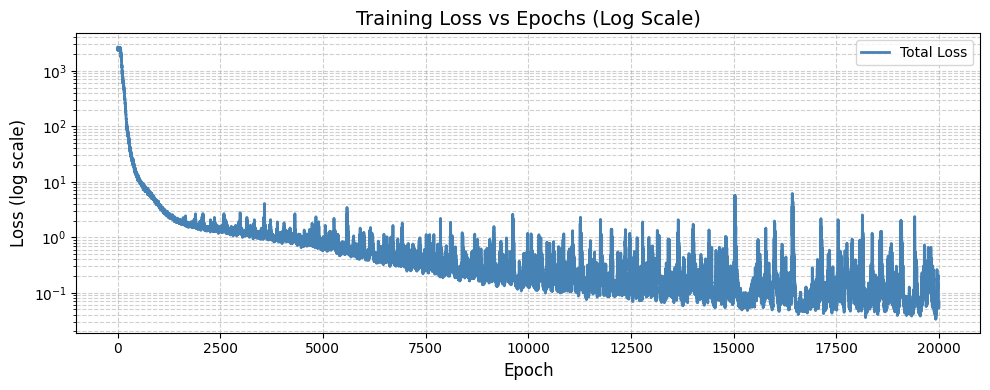

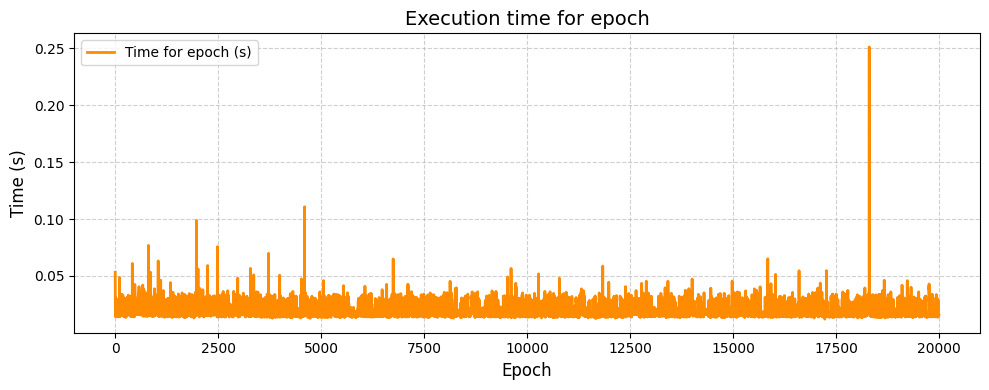

In [54]:
model_no_change_opt = PINN60()
train_plot(model_no_change_opt, epochs = 20000)

torch.save(model_no_change_opt.state_dict(), "PINN60.pth")

Epoch 0 - Loss: 2.480399e+03  [PDE: 2.48e+03, BC: 1.09e-02]
Epoch 500 - Loss: 1.156004e+01  [PDE: 4.72e+00, BC: 6.84e+00]
Epoch 1000 - Loss: 3.833547e+00  [PDE: 1.27e+00, BC: 2.56e+00]
Epoch 1500 - Loss: 2.236629e+00  [PDE: 6.26e-01, BC: 1.61e+00]
Epoch 2000 - Loss: 2.336756e+00  [PDE: 1.02e+00, BC: 1.32e+00]
Epoch 2500 - Loss: 2.103684e+00  [PDE: 9.80e-01, BC: 1.12e+00]
Epoch 3000 - Loss: 1.540663e+00  [PDE: 5.06e-01, BC: 1.03e+00]
Epoch 3500 - Loss: 1.209959e+00  [PDE: 3.82e-01, BC: 8.28e-01]
Epoch 4000 - Loss: 1.078731e+00  [PDE: 3.38e-01, BC: 7.41e-01]
Epoch 4500 - Loss: 8.728896e-01  [PDE: 2.56e-01, BC: 6.17e-01]
Epoch 5000 - Loss: 6.540640e-01  [PDE: 2.17e-01, BC: 4.37e-01]
Epoch 5500 - Loss: 5.286943e-01  [PDE: 2.08e-01, BC: 3.20e-01]
Epoch 6000 - Loss: 5.730966e-01  [PDE: 3.47e-01, BC: 2.26e-01]
Epoch 6500 - Loss: 3.911851e-01  [PDE: 2.44e-01, BC: 1.48e-01]
Epoch 7000 - Loss: 3.184793e-01  [PDE: 2.05e-01, BC: 1.14e-01]
Epoch 7500 - Loss: 2.102708e-01  [PDE: 1.31e-01, BC: 7.94e-

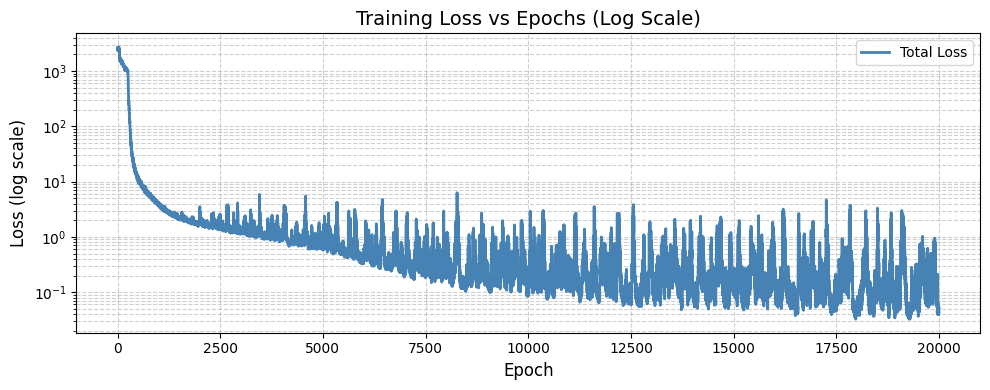

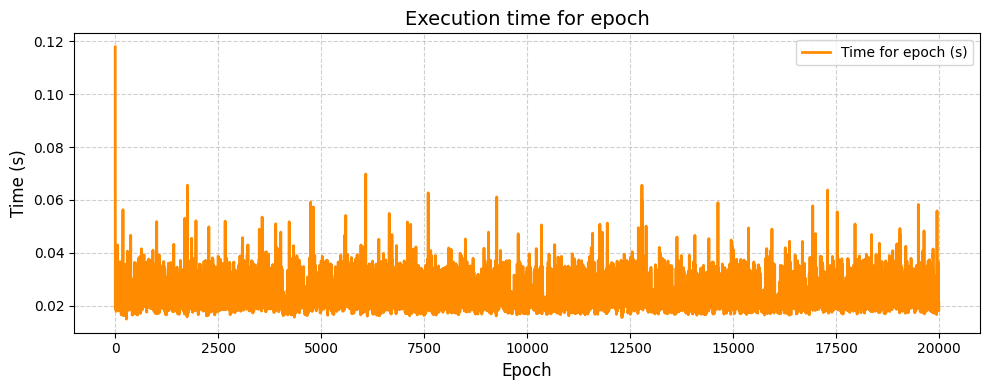

In [55]:
model_no_change_opt = PINN80()
train_plot(model_no_change_opt, epochs = 20000)

torch.save(model_no_change_opt.state_dict(), "PINN80.pth")

From a preliminary analyzes, we can understand that PINN80 is the worst nn that we implement. Endeed, the loss is less stable and with higher level.

Hence, the idea is to start to investigate the other two NN to understand with of them is a better performere. We want the the nn is stable, i.e. the loss has to have a constant decrescet behaviour, but also we want to reach a loss value around 1e-2, 1e-3.

**Improvements**. 
1. Improve the number of epochs
2. Change the optimizer
3. Change the activation function

In [74]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

def train_plot_LBFGS(model_no_change_opt, epochs=1000, lr=1.0, lambda_bc=1.0):
    model = model_no_change_opt
    mse_loss = nn.MSELoss()

    optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=lr,
        max_iter=500,
        history_size=50,
        line_search_fn="strong_wolfe"
    )

    loss_history = []
    epoch_times = []

    for epoch in range(epochs):
        epoch_start = time.time()

        model.train()

        # I dati vanno generati DENTRO al closure per permettere il ricalcolo con gradiente
        def closure():
            optimizer.zero_grad()

            # Rigenera i dati all'interno del closure
            x_in, mu_in, xb, mu_b = generate_data()
            x_in.requires_grad_()

            loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
            u_b = model(xb, mu_b)
            loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
            loss_total = loss_phys + lambda_bc * loss_bc

            loss_total.backward()
            # Salva anche le loss per logging
            closure.loss_phys = loss_phys
            closure.loss_bc = loss_bc
            closure.loss_total = loss_total
            return loss_total

        optimizer.step(closure)

        # Logging dopo closure
        loss_history.append(closure.loss_total.item())
        epoch_times.append(time.time() - epoch_start)

        if epoch % 50 == 0:
            print(f"Epoch {epoch} - Loss: {closure.loss_total.item():.6e}  "
                  f"[PDE: {closure.loss_phys.item():.2e}, BC: {closure.loss_bc.item():.2e}]")

    # Tempo medio
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"\n⏱ Mean time per epoch: {avg_epoch_time:.4f} s")

    # Plot della loss (log)
    plt.figure(figsize=(10, 4))
    plt.plot(loss_history, label="Total Loss", color="steelblue", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss (log scale)", fontsize=12)
    plt.title("Training Loss vs Epochs (Log Scale)", fontsize=14)
    plt.yscale("log")
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot tempo per epoca
    plt.figure(figsize=(10, 4))
    plt.plot(epoch_times, label="Time for epoch (s)", color="darkorange", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Time (s)", fontsize=12)
    plt.title("Execution time per epoch", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return loss_history, epoch_times


Epoch 0 - Loss: 4.936023e-02  [PDE: 2.53e-02, BC: 2.40e-02]
Epoch 50 - Loss: 4.850470e-02  [PDE: 2.30e-02, BC: 2.55e-02]
Epoch 100 - Loss: 5.205394e-02  [PDE: 2.47e-02, BC: 2.74e-02]
Epoch 150 - Loss: 5.286624e-02  [PDE: 2.67e-02, BC: 2.61e-02]
Epoch 200 - Loss: 5.374567e-02  [PDE: 2.31e-02, BC: 3.07e-02]
Epoch 250 - Loss: 4.596890e-02  [PDE: 2.07e-02, BC: 2.53e-02]
Epoch 300 - Loss: 4.794196e-02  [PDE: 2.42e-02, BC: 2.37e-02]
Epoch 350 - Loss: 4.925885e-02  [PDE: 2.34e-02, BC: 2.58e-02]
Epoch 400 - Loss: 4.647034e-02  [PDE: 2.02e-02, BC: 2.63e-02]
Epoch 450 - Loss: 4.812279e-02  [PDE: 2.28e-02, BC: 2.54e-02]
Epoch 500 - Loss: 4.887954e-02  [PDE: 2.50e-02, BC: 2.38e-02]
Epoch 550 - Loss: 4.866233e-02  [PDE: 2.30e-02, BC: 2.57e-02]
Epoch 600 - Loss: 4.403660e-02  [PDE: 2.04e-02, BC: 2.36e-02]
Epoch 650 - Loss: 4.780235e-02  [PDE: 2.29e-02, BC: 2.49e-02]
Epoch 700 - Loss: 4.812270e-02  [PDE: 2.53e-02, BC: 2.28e-02]
Epoch 750 - Loss: 5.031072e-02  [PDE: 2.60e-02, BC: 2.43e-02]
Epoch 800 -

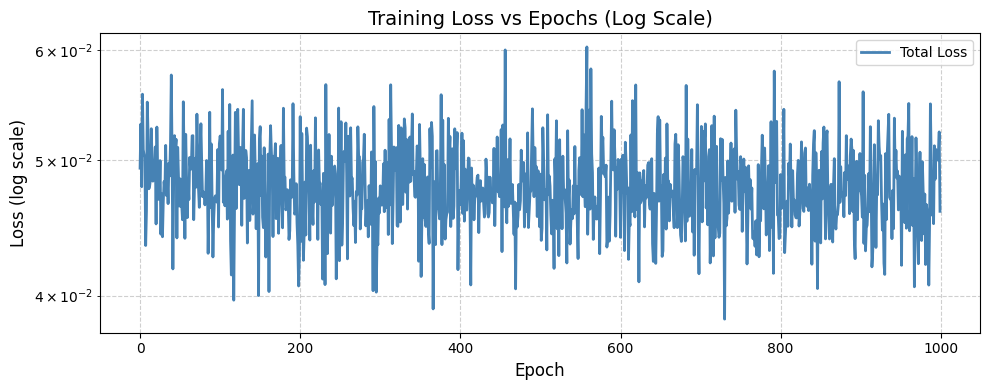

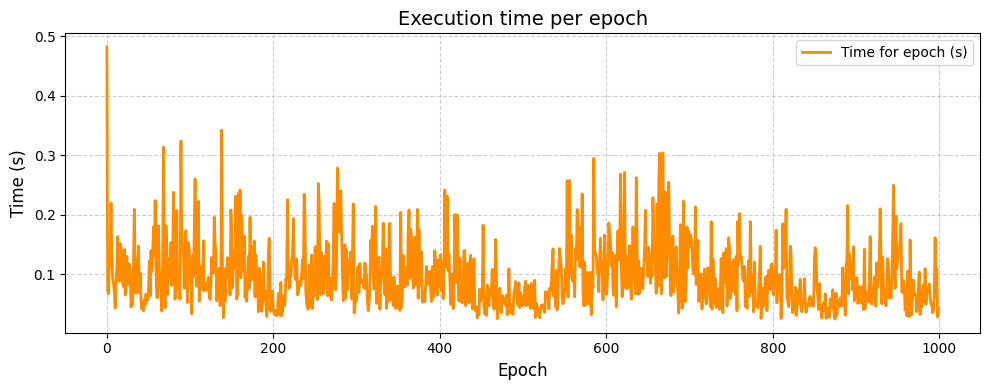

In [76]:
# CHANGE OPTIMIZER

# Ricrea un'istanza del modello (con la stessa architettura!)
model_PINN40 = PINN40()

# Carica i pesi salvati
model_PINN40.load_state_dict(torch.load("PINN40.pth"))

train_plot_LBFGS(model_PINN40, epochs = 1000)

torch.save(model_PINN40.state_dict(), "PINN40_lbfgs.pth")

Epoch 0 - Loss: 3.480549e-02  [PDE: 2.25e-02, BC: 1.23e-02]
Epoch 50 - Loss: 3.061368e-02  [PDE: 1.89e-02, BC: 1.17e-02]
Epoch 100 - Loss: 2.867681e-02  [PDE: 1.58e-02, BC: 1.29e-02]
Epoch 150 - Loss: 3.445182e-02  [PDE: 1.87e-02, BC: 1.57e-02]
Epoch 200 - Loss: 3.129695e-02  [PDE: 1.80e-02, BC: 1.33e-02]
Epoch 250 - Loss: 2.712394e-02  [PDE: 1.52e-02, BC: 1.19e-02]
Epoch 300 - Loss: 3.363655e-02  [PDE: 1.96e-02, BC: 1.40e-02]
Epoch 350 - Loss: 3.036756e-02  [PDE: 1.73e-02, BC: 1.30e-02]
Epoch 400 - Loss: 2.899387e-02  [PDE: 1.65e-02, BC: 1.25e-02]
Epoch 450 - Loss: 2.971656e-02  [PDE: 1.67e-02, BC: 1.31e-02]
Epoch 500 - Loss: 3.034380e-02  [PDE: 1.75e-02, BC: 1.28e-02]
Epoch 550 - Loss: 2.951941e-02  [PDE: 1.63e-02, BC: 1.32e-02]
Epoch 600 - Loss: 3.132001e-02  [PDE: 1.72e-02, BC: 1.41e-02]
Epoch 650 - Loss: 3.032326e-02  [PDE: 1.69e-02, BC: 1.34e-02]
Epoch 700 - Loss: 3.051766e-02  [PDE: 1.83e-02, BC: 1.22e-02]
Epoch 750 - Loss: 2.764669e-02  [PDE: 1.55e-02, BC: 1.21e-02]
Epoch 800 -

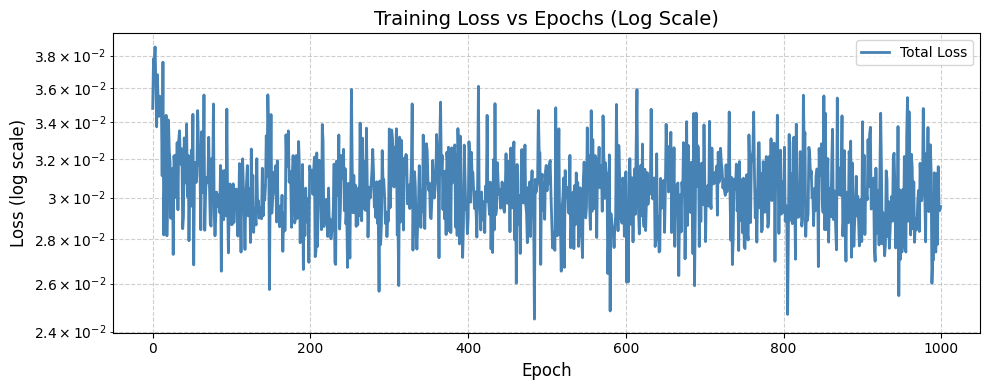

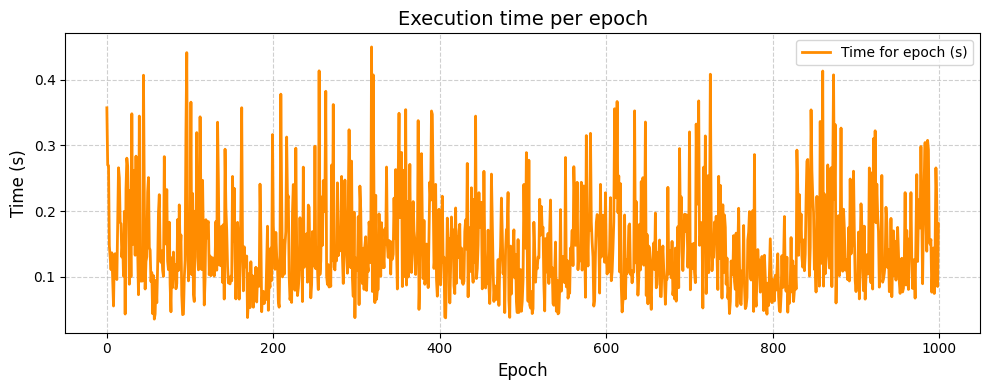

In [78]:
# CHANGE OPTIMIZER

# Ricrea un'istanza del modello (con la stessa architettura!)
model_PINN60 = PINN60()

# Carica i pesi salvati
model_PINN60.load_state_dict(torch.load("PINN60.pth"))

train_plot_LBFGS(model_PINN60, epochs = 1000)

torch.save(model_PINN40.state_dict(), "PINN60_lbfgs.pth")

In this case, the PINN60 has achieved better results. Now we try to change the activation function so that to understand which of them could be better. 

### Implementations of different NN to understand which of them is the best one

#### 1. **Fully connected (FC) classic - baseline**

* **Structure**: 5 hidden layers, 50 neurons/layer, `tanh`
* **Pro**: simple, stable
* **Expectation**: Loss ≈ 1e-2 → 1e-3 with tuning

---

#### 2. **FC with skip connections (residual PINN)**

* **Structure**: each layer also receives the initial input `(x, μ)`
* **Pro**: improves gradient propagation
* **Expectation**: Loss ≈ 1e-3 more easily

---

#### 3. **Fourier Feature Network (FFN)**

* **Structure**: first layer with `sin(2πBx)` (B = random frequencies), then FC
* **Pro**: represents high frequency functions well
* **Source**: \³[Tancik et al. 2020].
* **Expectation**: good for $g_2$ parametric

---

#### 4. **SIREN (sinusoidal representation networks)**

* **Activation**: `sin` on all layers
* **Pro**: effective for non-linear PDEs with oscillating components
* **Caution**: requires custom initialisation
* **Source**: \[Sitzmann et al., NeurIPS 2020].

---

#### 5. **DeepONet (Operator Network)**

* **Use**: if you want to extend to more $\mu$, map $\mu \to u(x)$
* **Pro**: powerful for parametric maps
* **Expectation**: Loss ≈ 1e-3 with few samples

---

#### 6. **Residual Deep Network (8-10 layers) with `Swish`**

* **Activation**: `Swish = x * sigmoid(x)`.
* **Pro**: improves smoothness over `ReLU` or `tanh`

---

#### 7. **PINN with self-adaptive weighting (SA-PINN)**

* **Idea**: The network dynamically learns the ${lambda$ balance between `loss_phys` and `loss_bc`.
* **Source**: Wang et al., "Understanding and mitigating gradient pathologies in PINNs".
* **Pro**: avoids manual tuning of λ

---

#### 8. **Modified Fourier Layer PINN**.

* **First layer**: sinusoidal (Fourier) coding + concatenation with `(x, µ)`
* **Poor**: classical FC
* **Pro**: improved generalisation over parameters

---

#### 9. **Meta-PINN (Meta-learning for fast adaptation)**

* **Pro**: quickly adapts the network to new parameters $\mu$.
* **Use**: if you need to generalise to new ${mu$ never seen before
* **Source**: Rao et al., "Meta-PINNs".

---

#### 10. **UNet-like (Encoder-Decoder) MLP**

* **Structure**: similar to UNet but all MLP, with symmetric skip connections
* **Pro**: useful for modelling multi-scale/multi-region solutions


In [95]:
import torch
import torch.nn as nn
import math

# Attivazioni custom
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

# 1. Fully Connected MLP standard
class FCNet(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=50, depth=5):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, mu):
        inp = torch.cat([x, mu], dim=1)
        return self.net(inp)

# 2. Residual FCNet (skip from input to all layers)
class ResFCNet(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=50, depth=5):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList([nn.Linear(hidden_dim + in_dim, hidden_dim) for _ in range(depth - 1)])
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x, mu):
        inp = torch.cat([x, mu], dim=1)
        h = torch.tanh(self.input(inp))
        for layer in self.hidden:
            h = torch.tanh(layer(torch.cat([h, inp], dim=1)))
        return self.out(h)

# 3. Fourier Feature Net
class FourierNet(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=50, depth=5, fourier_dim=30):
        super().__init__()
        B = torch.randn((in_dim, fourier_dim)) * 10
        self.register_buffer("B", B)
        self.fc = FCNet(in_dim=2 * fourier_dim, hidden_dim=hidden_dim, depth=depth)

    def forward(self, x, mu):
        inp = torch.cat([x, mu], dim=1)
        x_proj = 2 * math.pi * inp @ self.B
        encoded = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return self.fc.net(encoded)

# 4. SIREN
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features)
        self.is_first = is_first
        self.init_weights()
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.linear.in_features, 1 / self.linear.in_features)
            else:
                self.linear.weight.uniform_(-math.sqrt(6 / self.linear.in_features) / self.omega_0,
                                            math.sqrt(6 / self.linear.in_features) / self.omega_0)
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

class SIREN(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=4, omega_0=30):
        super().__init__()
        layers = [SineLayer(input_dim, hidden_dim, is_first=True, omega_0=omega_0)]
        for _ in range(num_layers - 1):
            layers.append(SineLayer(hidden_dim, hidden_dim, omega_0=omega_0))
        self.net = nn.Sequential(*layers)
        self.final = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        return self.final(self.net(x))


# 5. DeepONet
class DeepONet(nn.Module):
    def __init__(self, branch_in=2, trunk_in=2, hidden_dim=50):
        super().__init__()
        self.branch = nn.Sequential(
            nn.Linear(branch_in, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh()
        )
        self.trunk = nn.Sequential(
            nn.Linear(trunk_in, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh()
        )
        self.final = nn.Linear(hidden_dim, 1)

    def forward(self, x, mu):
        b = self.branch(mu)
        t = self.trunk(x)
        return self.final(b * t)

# 6. FCNet with Swish
class SwishNet(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=50, depth=5):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), Swish()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), Swish()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, mu):
        inp = torch.cat([x, mu], dim=1)
        return self.net(inp)

# 7. Self-Adaptive Weighting PINN (SA-PINN) 
class SAPINNWrapper(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        self.log_lambda = nn.Parameter(torch.tensor(0.0))  # inizializzato a log(1.0)

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, R, x_in, mu_in, xb, mu_b, mse_loss):
        x_in.requires_grad_()
        loss_phys = mse_loss(R(x_in, mu_in, self), torch.zeros_like(x_in[:, :1]))
        u_b = self(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # SA loss = L_bc + exp(-λ) * L_phys + λ
        lambda_weight = torch.exp(-self.log_lambda)
        total_loss = loss_bc + lambda_weight * loss_phys + self.log_lambda

        return total_loss, loss_phys.detach(), loss_bc.detach(), self.log_lambda.detach().exp()


# 8. Modified Fourier Layer PINN (same as FourierNet with custom B)
class FourierNetCustom(nn.Module):
    def __init__(self, input_dim, mapping_size=256, B=None, scale=10.0, hidden_dim=64, num_layers=4):
        super().__init__()
        if B is None:
            B = torch.randn((input_dim, mapping_size)) * scale
        self.register_buffer("B", B)
        self.mlp = FCNet(2 * mapping_size, hidden_dim, num_layers)

    def forward(self, x):
        x_proj = 2 * math.pi * x @ self.B
        x_enc = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return self.mlp(x_enc)

# 10. UNet-like MLP (simplified encoder-decoder with skip connections)
class UNetMLP(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=50):
        super().__init__()
        self.enc1 = nn.Linear(in_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dec1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, mu):
        inp = torch.cat([x, mu], dim=1)
        h1 = torch.tanh(self.enc1(inp))
        h2 = torch.tanh(self.enc2(h1))
        h = torch.cat([h1, h2], dim=1)
        h = torch.tanh(self.dec1(h))
        return self.dec2(h)

In [90]:
def train_adaptive(model, epochs=50000, lambda_bc=1.0, lr_adam=1e-3):
    import matplotlib.pyplot as plt
    import time
    mse_loss = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam)
    use_lbfgs = False

    loss_history = []
    epoch_times = []

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()

        if not use_lbfgs:
            # === FASE 1: Adam ===
            x_in, mu_in, xb, mu_b = generate_data()
            x_in.requires_grad_()

            optimizer.zero_grad()
            loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
            u_b = model(xb, mu_b)
            loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
            loss_total = loss_phys + lambda_bc * loss_bc

            loss_total.backward()
            optimizer.step()

            loss_val = loss_total.item()

            # Controllo: se siamo dopo 10.000 epoche e la loss è stabile → switch
            if epoch >= 15000:  # controlla ogni epoca DOPO le prime 10k
                prev_loss = loss_history[-1000]
                if prev_loss / loss_val < 10:  # non calata di almeno un ordine
                    print(f"\n🔁 Switching to L-BFGS at epoch {epoch}")
                    use_lbfgs = True
                    optimizer = torch.optim.LBFGS(
                        model.parameters(),
                        lr=1.0,
                        max_iter=500,
                        history_size=50,
                        line_search_fn="strong_wolfe"
                    )

        else:
            # === FASE 2: L-BFGS ===
            def closure():
                optimizer.zero_grad()
                x_in, mu_in, xb, mu_b = generate_data()
                x_in.requires_grad_()
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc
                loss_total.backward()
                closure.loss_val = loss_total.item()
                return loss_total

            optimizer.step(closure)
            loss_val = closure.loss_val

        loss_history.append(loss_val)
        epoch_times.append(time.time() - epoch_start)

        if epoch % 500 == 0:
            print(f"Epoch {epoch} - Loss: {loss_val:.6e}")

    # === Report finale
    avg_time = sum(epoch_times) / len(epoch_times)
    print(f"\n✅ Training complete. Avg epoch time: {avg_time:.4f}s")

    plt.figure(figsize=(10, 4))
    plt.plot(loss_history, label="Total Loss", color="navy")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss (log scale)")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return loss_history


In [89]:
# 1. Fully Connected MLP standard
FCNet_model = FCNet()
train_adaptive(FCNet_model)

torch.save(FCNet_model.state_dict(), "FCNet_model.pth")

Epoch 0 - Loss: 2.533960e+03
Epoch 500 - Loss: 7.658494e+01
Epoch 1000 - Loss: 1.087282e+01
Epoch 1500 - Loss: 5.750403e+00
Epoch 2000 - Loss: 2.766120e+00
Epoch 2500 - Loss: 2.118245e+00
Epoch 3000 - Loss: 1.806841e+00
Epoch 3500 - Loss: 2.115404e+00
Epoch 4000 - Loss: 2.054581e+00
Epoch 4500 - Loss: 1.370426e+00
Epoch 5000 - Loss: 1.448063e+00
Epoch 5500 - Loss: 2.294265e+00
Epoch 6000 - Loss: 2.247014e+00
Epoch 6500 - Loss: 1.446577e+00
Epoch 7000 - Loss: 1.000331e+00
Epoch 7500 - Loss: 7.927403e-01
Epoch 8000 - Loss: 8.284473e-01
Epoch 8500 - Loss: 2.112099e+00
Epoch 9000 - Loss: 2.519193e+00
Epoch 9500 - Loss: 6.363599e-01
Epoch 10000 - Loss: 5.297241e-01
Epoch 10500 - Loss: 4.383777e-01

🔁 Switching to L-BFGS at epoch 11000
Epoch 11000 - Loss: 1.406881e+00
Epoch 11500 - Loss: 2.513514e-01
Epoch 12000 - Loss: 2.522735e-01
Epoch 12500 - Loss: 2.576804e-01
Epoch 13000 - Loss: 2.683089e-01
Epoch 13500 - Loss: 2.573088e-01
Epoch 14000 - Loss: 2.492756e-01
Epoch 14500 - Loss: 2.577347e

KeyboardInterrupt: 

In [91]:
# 2. Residual FCNet (skip from input to all layers)
ResFCNet_model = ResFCNet()
train_adaptive(ResFCNet_model)

torch.save(ResFCNet_model.state_dict(), "ResFCNet_model.pth")

Epoch 0 - Loss: 2.650240e+03
Epoch 500 - Loss: 3.425285e+01
Epoch 1000 - Loss: 8.119417e+00
Epoch 1500 - Loss: 3.292922e+00
Epoch 2000 - Loss: 1.972460e+00
Epoch 2500 - Loss: 1.638514e+00
Epoch 3000 - Loss: 2.307236e+00
Epoch 3500 - Loss: 2.051628e+00
Epoch 4000 - Loss: 1.480181e+00
Epoch 4500 - Loss: 7.736382e-01
Epoch 5000 - Loss: 1.051957e+00
Epoch 5500 - Loss: 4.823986e-01
Epoch 6000 - Loss: 3.734612e-01
Epoch 6500 - Loss: 3.537703e-01
Epoch 7000 - Loss: 2.889914e-01
Epoch 7500 - Loss: 2.334618e-01
Epoch 8000 - Loss: 3.295418e-01
Epoch 8500 - Loss: 2.106254e-01
Epoch 9000 - Loss: 3.316882e-01
Epoch 9500 - Loss: 1.396011e-01
Epoch 10000 - Loss: 2.479925e-01
Epoch 10500 - Loss: 1.539525e-01
Epoch 11000 - Loss: 2.436744e-01
Epoch 11500 - Loss: 1.708377e+00
Epoch 12000 - Loss: 1.966716e-01
Epoch 12500 - Loss: 4.062643e-01
Epoch 13000 - Loss: 1.314155e-01
Epoch 13500 - Loss: 8.376342e-02
Epoch 14000 - Loss: 1.142458e-01
Epoch 14500 - Loss: 1.895720e-01

🔁 Switching to L-BFGS at epoch 15

KeyboardInterrupt: 

In [92]:
# 3. Fourier Feature Net
FourierNet_model = FourierNet()
train_adaptive(FourierNet_model)

torch.save(FourierNet_model.state_dict(), "FourierNet_model.pth")

Epoch 0 - Loss: 8.869354e+04
Epoch 500 - Loss: 2.442389e+03
Epoch 1000 - Loss: 2.626005e+03
Epoch 1500 - Loss: 2.397770e+03
Epoch 2000 - Loss: 2.278952e+03
Epoch 2500 - Loss: 2.486050e+03
Epoch 3000 - Loss: 2.504975e+03
Epoch 3500 - Loss: 2.524382e+03
Epoch 4000 - Loss: 2.615255e+03
Epoch 4500 - Loss: 2.490412e+03
Epoch 5000 - Loss: 2.502350e+03
Epoch 5500 - Loss: 2.299731e+03
Epoch 6000 - Loss: 2.447854e+03
Epoch 6500 - Loss: 2.454850e+03
Epoch 7000 - Loss: 2.530437e+03


KeyboardInterrupt: 

In [96]:
# 4. SIREN
SIREN_model = SIREN()
train_adaptive(SIREN_model)

torch.save(SIREN_model.state_dict(), "SIREN_model.pth")

TypeError: SIREN.forward() takes 2 positional arguments but 3 were given

In [ ]:
#CHE è STA ROBA??? ULTIMO PLOT FATTO NEL LAB DEL PINN
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).detach().numpy()
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).detach().numpy()
R_u = 6*np.exp(-3*pt_x - 2*pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# 3 POD-NN

In [105]:
# define the net and its dimensions
mu_dim = 2 
basis_dim = N #N=3 --> found doing POD
input_dim = mu_dim # net takes mu=(mu_0,mu_1) as input
output_dim = basis_dim # net outputs a reduced solution uN of dim N=3
nodes = 40

#let us use this net for now, then we'll see
class Net(nn.Module):
    def __init__(self):
         super(Net, self).__init__()
         # Starting layer
         self.fc1 = nn.Linear(input_dim, nodes)
        
         # Hidden layer
         self.fc2 = nn.Linear(nodes, nodes)
         self.fc3 = nn.Linear(nodes, nodes)
         self.fc4 = nn.Linear(nodes, nodes)
         # Finish hidden layer
         # Last layer
         self.fc5 = nn.Linear(nodes, output_dim)
        
         self.tanh = nn.Tanh()
     # self.apply(self._init_weights)
    def forward(self, x): ### Forward law ----> prediction
         # Activation function
         x = self.tanh(self.fc1(x)) # Iperbolic tangent [-1, 1]
         x = self.tanh(self.fc2(x))
         x = self.tanh(self.fc3(x))
         x = self.tanh(self.fc4(x))
        
         x = self.fc5(x) # This is the output, we do not change the range of the solution
         # It is better to leave the final solution in the space where it is to do not modify it
        
         return x

#### Training step

In [106]:
#set seed
seed_num = 23 # You can change this, different seed == different initialization of weight --> maybe better performance
torch.manual_seed(seed_num)

# call model, loss and optimizer (to be changed maybe)
model = Net()
torch.set_default_dtype(torch.float32)
loss = nn.MSELoss() # MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# define the training parameters
epoch_max = 500000
epoch = 0
tol = 1e-5
running_loss = 1. # To start the optimization

Recall the terms we use in POD-NN
- `snapshots_matrix` : snapshot matrix obtained during POD
- `basis_function`: it is $\mathbb{B}\in \mathbb{R}^{N_{\delta} \times N}$ basis matrix made of the first $N=3$ normalized eigenvectors of the covariance matrix `C = snapshots_matrix @ inner_product @ np.transpose(snapshots_matrix) `
- inner_product : it is  $ \mathbb{X} $, the stiffness matrix obtained assembling the linear part of the problem:

  `[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)`
then `reduced_inner_product` = $ \mathbb{X}_N = \mathbb{B}^T \mathbb{X} \mathbb{B} \in \mathbb{R}^{N\times N}$

- training_set = [sample_mu_0, sample_mu_1] parameters used to build the snapshots during POD
- `projected_snapshot`:  $u_N$ solution of $\mathbb{X}_N u_N = \mathbb{B}^T \mathbb{X} u_{delta} $ where $u_{delta}$ snapshot

In [107]:
# Reshape to column vectors
sample_mu_0 = sample_mu_0.reshape(-1, 1)  # shape: (200, 1)
sample_mu_1 = sample_mu_1.reshape(-1, 1)  # shape: (200, 1)

# Now concatenate column-wise
training_set = np.hstack((sample_mu_0, sample_mu_1))

In [108]:
print(training_set.shape)

(100, 2)


In [109]:
# training set definition
# NB: x (= input of model) = mu , y (=output of model) = uN

reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
# training_set = np.concatenate((sample_mu_0, sample_mu_1)) # sample of patrameters mu_0, mu_1 used to find the snapshots
mu_train = torch.tensor(np.float32(training_set)) # The input are all the parameters that I have
uN_train = []
for i in range(snapshots_matrix.shape[0]):
    snapshot_to_project = snapshots_matrix[i]
    # We have to solve X_N u_rb = B^T X_delta u_delta
    projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
    uN_train.append(projected_snapshot) # On dimension N=3
uN_train = np.float32(uN_train)
uN_train = torch.tensor(uN_train) # To np object to tensor

In [110]:
##### TRAINING LOOP #######
while running_loss >= tol and epoch < epoch_max:
    epoch = epoch + 1
    optimizer.zero_grad()
    
    ## compute output
    uN_pred = model(mu_train) # Net apply to my parameter --> to each parameter I have a solution in dimension 9 that are the projection
    
    running_loss = loss(uN_pred, uN_train) # Computing the loss
    
    if epoch >= 20000:
        optimizer.param_groups[0]['lr'] = 0.0001 # To change the learning rate during the epoch with a dictionary
    
    #compute the gradients
    running_loss.backward()
    
    # optimizer update
    optimizer.step()
    
    if epoch % 600 == 199:
        print("epoch", epoch, 'loss', running_loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

epoch 199 loss 13.4779634475708 lr 0.001
epoch 799 loss 0.6335645318031311 lr 0.001
epoch 1399 loss 0.17932628095149994 lr 0.001
epoch 1999 loss 0.05479748919606209 lr 0.001
epoch 2599 loss 0.017116766422986984 lr 0.001
epoch 3199 loss 0.006071981508284807 lr 0.001
epoch 3799 loss 0.002323852851986885 lr 0.001
epoch 4399 loss 0.0010099336504936218 lr 0.001
epoch 4999 loss 0.0004968915600329638 lr 0.001
epoch 5599 loss 0.00027531920932233334 lr 0.001
epoch 6199 loss 0.00017014140030369163 lr 0.001
epoch 6799 loss 0.00011670866661006585 lr 0.001
epoch 7399 loss 8.537450048606843e-05 lr 0.001
epoch 7999 loss 6.41397200524807e-05 lr 0.001
epoch 8599 loss 5.0136237405240536e-05 lr 0.001
epoch 9199 loss 4.060434366692789e-05 lr 0.001
epoch 9799 loss 3.3343832910759374e-05 lr 0.001
epoch 10399 loss 2.9008118872297928e-05 lr 0.001
epoch 10999 loss 2.7155520001542754e-05 lr 0.001
epoch 11599 loss 2.3411303118336946e-05 lr 0.001
epoch 12199 loss 2.464214230712969e-05 lr 0.001
epoch 12799 loss 2.

### Testing step

In [124]:
########### TESTING PHASE ##############
mu_0 = 0.23
mu_1 = 0.54
mu_test = [mu_0, mu_1]
#mu_test = np.random.uniform(low=0.1, high=1, size=(1, 2))  
#mu_test = np.float32(mu_test)
mu_test_tensor = torch.tensor(mu_test)
reduced_solution = np.asarray(model(mu_test_tensor).detach().numpy())[0] # To make comparison wrt the other
print(reduced_solution) # In dimension 3

-2.1081152


In [128]:
basis_functions

array([[-6.59834326e-03, -2.39318492e-03,  1.99472054e-03],
       [ 5.56502328e-02,  5.78301932e-02, -5.78900611e-02],
       [-6.27679168e-02, -6.05307328e-02,  6.01720867e-02],
       [ 5.69383415e-02,  5.91350172e-02, -5.91964209e-02],
       [-2.99044527e-03, -4.82701722e-04,  2.43769205e-04],
       [ 1.55458434e-01,  1.57675303e-01, -1.57802320e-01],
       [-5.02433054e-02, -4.96151104e-02,  4.96652997e-02],
       [ 3.92502837e-02,  4.05102323e-02, -4.05265516e-02],
       [ 1.03793206e-01,  1.05085195e-01, -1.05165804e-01],
       [ 8.44210505e-02,  8.55231759e-02, -8.55828267e-02],
       [ 8.14888281e-02,  8.27969161e-02, -8.28477052e-02],
       [ 2.55582984e-02,  2.62339406e-02, -2.62427500e-02],
       [-1.03250353e-02, -9.67295054e-03,  9.69286826e-03],
       [-2.55599378e-02, -2.52244961e-02,  2.52520119e-02],
       [-3.61466079e-02, -3.59051244e-02,  3.59425260e-02],
       [ 2.85790341e-01,  2.90437996e-01, -2.90761070e-01],
       [ 2.48256570e-01,  2.51830499e-01

In [125]:
# Project the solution to see it : CAPISCI
nn_proj_reduced_solution = basis_functions @ reduced_solution
gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, np.zeros(problemData['NumberStrongs'])) 

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [113]:
print(nn_proj_reduced_solution)

[-8.36653429e-03  2.63662225e-01 -2.73294753e-01  2.69573596e-01
 -7.25300827e-04  7.14889006e-01 -2.23399192e-01  1.84541894e-01
  4.76263229e-01  3.87696108e-01  3.75648845e-01  1.19359120e-01
 -4.28991124e-02 -1.13547386e-01 -1.61901951e-01  1.31695154e+00
  1.14158933e+00  8.72728098e-01  6.93730468e-01  1.07160604e+00
  1.07567145e+00  8.45125748e-01  6.01534799e-01  1.10184390e+00
  8.01157802e-01  4.16500928e-01  1.10623818e+00  2.61028899e-01
  1.33035698e+00  1.11563893e+00  1.21763594e+00  1.32144608e+00
  1.05323104e+00  1.20176831e+00  1.04735983e+00  6.20489361e-01
  6.83627699e-01  2.35434678e-01  3.95398868e-01  6.28842842e-01
  7.66656090e-01 -1.90385712e-02  7.66872882e-01 -2.49790730e-01
  2.85637597e-01 -2.84170684e-02  3.59771076e-01  2.04259366e-02
 -4.92866075e-02  4.57506767e-01 -4.25526829e-01  4.27359572e-01
  4.05613315e-03 -2.21226276e-01 -5.91516067e-01  1.04269815e+00
  4.88136407e-03 -2.99586982e-01 -4.09559371e-02 -2.44649636e-01
 -6.16416268e-02 -3.30044

In [123]:
mu_test

array([[0.49271291, 0.2902197 ]], dtype=float32)

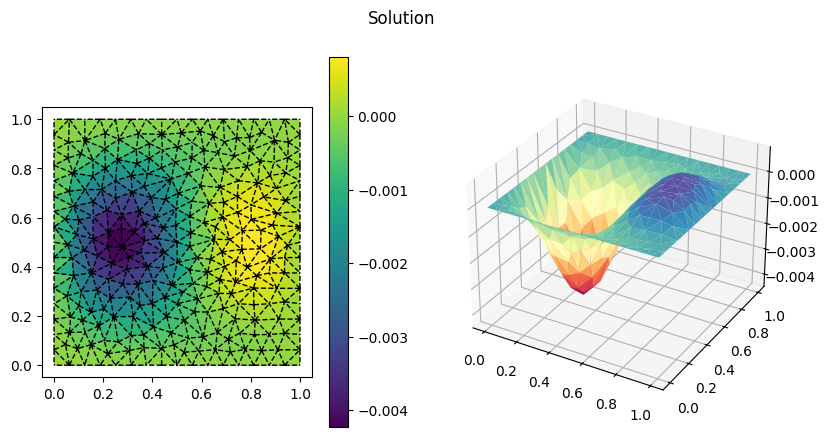

In [114]:
mu_0 = mu_test[0]
mu_1 = mu_test[1]
mu_test
# Linear
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
# Non linear 
[reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)

# 2- Right hand side of the function

# Linear part
forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)
# Non linear part
forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)

# Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
full_solution = gedim.LUSolver(stiffness + reaction, \
        forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
        lib)
gedim.PlotSolution(mesh, dofs, strongs, full_solution, np.zeros(problemData['NumberStrongs'])) # Plotting the FOM solution (the ground trouth)

In [115]:
print(full_solution)

[-1.65811843e-03  2.85313981e-04 -2.02671068e-03  2.87548194e-04
 -9.85695913e-04  6.57250622e-04 -6.43278204e-05  3.06108448e-04
  4.44163276e-04  3.98189861e-04  4.40990129e-04  1.96328827e-04
  7.73930503e-05 -2.17170464e-05 -5.77247062e-05  7.68292708e-04
  8.24908943e-04  7.36906517e-04  6.04387921e-04  4.91700014e-04
  8.01788976e-04  7.10660138e-04  5.83065546e-04  8.00290027e-04
  6.92638030e-04  3.86706615e-04  7.73216525e-04  3.49104077e-04
  7.52908091e-04  2.70557213e-04  6.83510173e-04  5.96622475e-04
  4.62366056e-04  4.43720149e-04  6.76534331e-04 -4.28550983e-04
  5.38457338e-04 -2.99013919e-04  1.69215958e-04  4.08159395e-05
  3.94103659e-04 -1.45127122e-03 -1.34598555e-04 -2.41025037e-04
 -6.29961558e-04 -1.11853255e-03 -7.74233155e-04 -1.13139144e-03
 -1.67412474e-03 -7.56723864e-04 -2.35447412e-03 -8.29051575e-04
 -1.54164104e-03 -1.82616735e-03 -2.78781920e-03  2.67967433e-04
 -2.42779319e-05 -1.10269695e-04 -3.01157563e-04 -1.26699693e-04
  8.33717007e-05 -1.72004

In [117]:
#Let us perform an error analysis and comment on the speed up!
abs_err = []
rel_err = []
testing_set = np.random.uniform(low=0.1, high=1, size=(10, 2))
speed_up = []
print("Computing error and speedup analysis") # Compute the erorr
for mu in testing_set:
    mu_0 = mu[0]
    mu_1 = mu[1]
    #### ASSEMBLE STUFF PARAMETER DEPENDANT #####
    # FULL
    # Non linear 
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
    # Non linear part
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
    
    lhs = stiffness + reaction
    rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
    ##### full #####
    start_fom = time.time()
    full_solution = gedim.LUSolver(lhs, rhs, lib)
    time_fom = time.time() - start_fom
    
    #### reduced #####
    mu_test = [[mu[0], mu[1]]]
    mu_test = np.float32(mu_test)
    mu_test_tensor = torch.tensor(mu_test)
    start_rom = time.time()
    reduced_solution = np.asarray(model(mu_test_tensor).detach().numpy())[0]
    time_rom = time.time() - start_rom
    
    speed_up.append(time_fom/(time_rom))
    
    proj_reduced_solution = basis_functions@reduced_solution
    # gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, Dirichlet_top)
    ### computing error
    error_function = full_solution - proj_reduced_solution
    error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    print(absolute_error)
    abs_err.append(absolute_error)
    
    full_solution_norm_squared_component = np.transpose(full_solution) @ inner_product @ full_solution
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    print(relative_error)
    
    # There are a lot of variablity in the errors

Computing error and speedup analysis
4.507659769460612
344.1378660352897
4.515263786610395
436.9533190491183
4.510167424678192
191.87702325064382
4.513962548750632
592.5181801555658
4.517650470756971
725.5195906800669
4.510476417111294
241.16110046214817
4.513043962140498
212.38953482488057
4.511606768380936
245.2806237266345
4.519739946392471
295.31790793080876
4.5152424747750315
188.74424291449125


In [ ]:
class PINN40(nn.Module):
    def __init__(self):
        super(PINN40, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )

    def forward(self, x, mu):
        input = torch.cat((x, mu), dim=1)  # x.shape = [batch, 2], mu.shape = [batch, 2]
        return self.net(input)